In [1]:
# Cell 1 — environment checks (run first)
import sys, pathlib, os
print("cwd:", pathlib.Path.cwd())
print("python executable:", sys.executable)
print("venv name (last part of path):", pathlib.Path(sys.executable).parents[1].name if len(pathlib.Path(sys.executable).parents)>1 else "")

cwd: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/python
python executable: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/venv/bin/python
venv name (last part of path): venv


In [2]:
# Cell 2 — import check for compute_indicators
import sys
from pathlib import Path

proj = Path.cwd()
pyfolder = proj / "python"
if str(pyfolder) not in sys.path:
    sys.path.insert(0, str(pyfolder))
print("python/ on sys.path?", str(pyfolder) in sys.path)

try:
    from compute_indicators import build_master
    print("Imported build_master from python/compute_indicators.py")
    use_module = True
except Exception as e:
    print("Import failed:", repr(e))
    use_module = False

python/ on sys.path? True
Import failed: ModuleNotFoundError("No module named 'compute_indicators'")


In [3]:
# List files in the current folder (python/)
from pathlib import Path
p = Path.cwd()
print("cwd:", p)
print("Files and folders here:")
for f in sorted(p.iterdir()):
    print("-", f.name)

cwd: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/python
Files and folders here:
- 01_fsa.ipynb
- 02_crime.ipynb
- 03_parks.ipynb
- 04_merge_index.ipynb


In [5]:
# Cell: define pipeline functions (run once at top of notebook)
# Minimal, teacher-style functions: load FSA, compute crime & parks indices, combine, export
from pathlib import Path
import logging
import pandas as pd
import geopandas as gpd
import numpy as np

logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("notebook_pipeline")

def normalize_series(s: pd.Series, invert: bool = False) -> pd.Series:
    s = s.fillna(0).astype(float)
    lo = s.min()
    hi = s.max()
    if hi == lo:
        return pd.Series(0.0, index=s.index)
    scaled = (s - lo) / (hi - lo)
    return 1.0 - scaled if invert else scaled

def load_fsa(fsa_path):
    p = Path(fsa_path)
    logger.info(f"Loading FSA polygons from {p}")
    gdf = gpd.read_file(p)
    # standardize column
    if "FSA" not in gdf.columns and "fsa" in gdf.columns:
        gdf = gdf.rename(columns={"fsa":"FSA"})
    if "FSA" not in gdf.columns:
        gdf["FSA"] = gdf.index.astype(str)
    return gdf

def compute_crime_index(fsa_gdf, crime_path=None, population_field=None):
    fsa = fsa_gdf.copy()
    fsa = fsa.to_crs(epsg=3857)
    fsa["crime_count"] = 0
    fsa["crime_score"] = 0.0
    if crime_path and Path(crime_path).exists():
        logger.info(f"Loading crime points from {crime_path}")
        crimes = gpd.read_file(crime_path).to_crs(epsg=3857)
        joined = gpd.sjoin(crimes, fsa[["FSA","geometry"]], how="left", predicate="within")
        counts = joined.groupby("FSA").size().rename("crime_count")
        fsa = fsa.merge(counts, on="FSA", how="left")
        fsa["crime_count"] = fsa["crime_count"].fillna(0).astype(int)
        if population_field and population_field in fsa.columns:
            fsa["crime_rate"] = fsa["crime_count"] / fsa[population_field].replace({0: np.nan}) * 1000
            fsa["crime_score"] = normalize_series(fsa["crime_rate"], invert=True)
        else:
            fsa["crime_score"] = normalize_series(fsa["crime_count"], invert=True)
    else:
        logger.info("No crime data found; crime_score left as 0.")
    return fsa.to_crs(epsg=4326)

def compute_parks_index(fsa_gdf, parks_path=None, buffer_m=800):
    fsa = fsa_gdf.copy()
    fsa = fsa.to_crs(epsg=3857)
    fsa["parks_count"] = 0
    fsa["parks_score"] = 0.0
    if parks_path and Path(parks_path).exists():
        logger.info(f"Loading parks from {parks_path}")
        parks = gpd.read_file(parks_path).to_crs(epsg=3857)
        buffers = fsa.copy()
        buffers["geometry"] = buffers.geometry.buffer(buffer_m)
        joined = gpd.sjoin(parks, buffers[["FSA","geometry"]], how="inner", predicate="within")
        counts = joined.groupby("FSA").size().rename("parks_count")
        fsa = fsa.merge(counts, on="FSA", how="left")
        fsa["parks_count"] = fsa["parks_count"].fillna(0).astype(int)
        fsa["parks_score"] = normalize_series(fsa["parks_count"])
    else:
        logger.info("No parks data found; parks_score left as 0.")
    return fsa.to_crs(epsg=4326)

def combine_scores(fsa_gdf, weights=None):
    fsa = fsa_gdf.copy()
    if weights is None:
        weights = {"safety":0.4, "parks":0.3, "transit":0.2, "price":0.1}
    total = sum(weights.values()) if weights else 1.0
    total = total if total > 0 else 1.0
    combined = pd.Series(0.0, index=fsa.index)
    for key, w in weights.items():
        col = f"{key}_score" if not key.endswith("_score") else key
        if col not in fsa.columns:
            fsa[col] = 0.0
        combined = combined + fsa[col].fillna(0).astype(float) * (w / total)
    fsa["final_score"] = combined
    fsa["combined_score"] = fsa["final_score"]
    return fsa

def build_master_in_notebook(fsa_path, crime_path=None, parks_path=None, out_path="data/processed/fsa_master.geojson", weights=None, population_field=None):
    # Load base FSA
    base = load_fsa(fsa_path)
    # compute crime and parks (returns GeoDataFrames in EPSG:4326)
    crime_gdf = compute_crime_index(base, crime_path=crime_path, population_field=population_field)
    parks_gdf = compute_parks_index(base, parks_path=parks_path)
    # merge by FSA (keep geometry from base)
    merged = base.copy()
    for df in (crime_gdf, parks_gdf):
        cols = [c for c in df.columns if c not in ["geometry"]]
        merged = merged.merge(df[cols], on="FSA", how="left")
    merged = combine_scores(merged, weights)
    outp = Path(out_path)
    outp.parent.mkdir(parents=True, exist_ok=True)
    merged.to_crs(epsg=4326).to_file(outp, driver="GeoJSON")
    logger.info(f"Wrote master GeoJSON to {outp}")
    return merged

In [6]:
# Run this cell to auto-detect raw files, run the pipeline, and show a short summary.
from pathlib import Path
import geopandas as gpd

proj_root = Path.cwd().parent
RAW = proj_root / "data" / "raw"

def first_file(foldername, exts=("*.geojson","*.json","*.shp","*.gpkg","*.csv")):
    folder = RAW / foldername
    if not folder.exists():
        return None
    for ext in exts:
        matches = sorted(folder.glob(ext))
        if matches:
            return matches[0]
    return None

fsa_path = first_file("fsa")
crime_path = first_file("crime")
parks_path = first_file("parks")
transit_path = first_file("transit")  # optional
rent_path = first_file("rent") or first_file("price")  # optional

print("Detected files:")
print(" project root:", proj_root)
print(" FSA:", fsa_path)
print(" Crime:", crime_path)
print(" Parks:", parks_path)
print(" Transit:", transit_path)
print(" Rent/price:", rent_path)

# Run the pipeline (this will write data/processed/fsa_master.geojson)
out_path = proj_root / "data" / "processed" / "fsa_master.geojson"
try:
    merged = build_master_in_notebook(str(fsa_path), crime_path=str(crime_path) if crime_path else None, parks_path=str(parks_path) if parks_path else None, out_path=str(out_path))
    print("Pipeline finished. Wrote master GeoJSON to:", out_path)
    # quick inspect
    print("Processed file CRS:", merged.crs)
    print("Columns:", list(merged.columns))
    display(merged.head())
except Exception as e:
    print("Pipeline failed with error:")
    import traceback
    traceback.print_exc()

INFO:notebook_pipeline:Loading FSA polygons from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson


Detected files:
 project root: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas
 FSA: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson
 Crime: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/crime/actes-criminels.json
 Parks: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/parks/espace_vert.geojson
 Transit: None
 Rent/price: None


INFO:notebook_pipeline:Loading crime points from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/crime/actes-criminels.json


Pipeline failed with error:


Traceback (most recent call last):
  File "/Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/venv/lib/python3.13/site-packages/pandas/core/indexes/base.py", line 3812, in get_loc
    return self._engine.get_loc(casted_key)
           ~~~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
  File "pandas/_libs/index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7088, in pandas._libs.hashtable.PyObjectHashTable.get_item
  File "pandas/_libs/hashtable_class_helper.pxi", line 7096, in pandas._libs.hashtable.PyObjectHashTable.get_item
KeyError: 'crime_count'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/var/folders/sp/ncf_7dk94k1gshvvrt4r_hth0000gn/T/ipykernel_13073/2704359425.py", line 35, in <module>
    merged = build_master_in_notebook(str(fsa_path), crime_path=str(crime_p

In [7]:
# Diagnostic: inspect FSA, crime, joined and counts to find merge problem
from pathlib import Path
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point

proj_root = Path.cwd().parent
fsa_path = proj_root / "data" / "raw" / "fsa" / "Montreal_fsa.geojson"
crime_path = proj_root / "data" / "raw" / "crime" / "actes-criminels.json"

print("FSA path:", fsa_path.exists(), fsa_path)
print("Crime path:", crime_path.exists(), crime_path)

# Load FSA and show columns and types
fsa = load_fsa(str(fsa_path))
print("\nFSA columns:", list(fsa.columns))
print("FSA dtypes:\n", fsa.dtypes)
print("FSA sample (first 5 rows):")
display(fsa.head())

# Ensure FSA has an 'FSA' column and show unique sample values
if "FSA" in fsa.columns:
    print("Sample FSA values:", fsa["FSA"].head().tolist())
else:
    print("No 'FSA' column found in FSA GeoDataFrame!")

# Load crimes and inspect
crimes = gpd.read_file(crime_path)
print("\nCrimes columns:", list(crimes.columns))
print("Crimes geometry types (unique):", crimes.geom_type.unique())
print("Crimes sample (first 5 rows):")
display(crimes.head())

# Reproject both to metric for spatial join
fsa_m = fsa.to_crs(epsg=3857)[["FSA","geometry"]]
crimes_m = crimes.to_crs(epsg=3857)

# Perform spatial join and inspect
joined = gpd.sjoin(crimes_m, fsa_m, how="left", predicate="within")
print("\nJoined columns:", list(joined.columns))
print("Joined sample (first 8 rows):")
display(joined.head(8))

# Show how many crimes got matched to an FSA vs unmatched
matched = joined["FSA"].notna().sum()
total = len(joined)
print(f"Matched crimes to FSA: {matched}/{total} ({matched/total:.2%})")

# Compute counts series and show
counts = joined.groupby("FSA").size().rename("crime_count")
print("\nCounts Series head (index dtype and sample):")
print("Index dtype:", counts.index.dtype)
display(counts.head(10))

# Try merging counts back to fsa_m (simulate merge) and show result columns
merged_sim = fsa_m.merge(counts.reset_index(), on="FSA", how="left")
print("\nAfter merge - columns:", list(merged_sim.columns))
print("crime_count column present?:", "crime_count" in merged_sim.columns)
display(merged_sim.head(8))

INFO:notebook_pipeline:Loading FSA polygons from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson


FSA path: True /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson
Crime path: True /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/crime/actes-criminels.json

FSA columns: ['CFSAUID', 'PRUID', 'PRNAME', 'geometry', 'FSA']
FSA dtypes:
 CFSAUID       object
PRUID         object
PRNAME        object
geometry    geometry
FSA           object
dtype: object
FSA sample (first 5 rows):


,CFSAUID,PRUID,PRNAME,geometry,FSA
0,H0M,24,Quebec / Québec,"MULTIPOLYGON (((-74.5196 45.03463, -74.51939 4...",0
1,H1A,24,Quebec / Québec,"MULTIPOLYGON (((-73.47668 45.70214, -73.47722 ...",1
2,H3Z,24,Quebec / Québec,"MULTIPOLYGON (((-73.58887 45.49044, -73.58634 ...",2
3,H3Y,24,Quebec / Québec,"MULTIPOLYGON (((-73.60089 45.49426, -73.60104 ...",3
4,H1B,24,Quebec / Québec,"MULTIPOLYGON (((-73.50219 45.65192, -73.50231 ...",4


Sample FSA values: ['0', '1', '2', '3', '4']

Crimes columns: ['CATEGORIE', 'DATE', 'QUART', 'PDQ', 'X', 'Y', 'LONGITUDE', 'LATITUDE', 'geometry']
Crimes geometry types (unique): ['Point']
Crimes sample (first 5 rows):


,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE,geometry
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-73.62678 45.56778)
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-73.62678 45.56778)
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,POINT (-73.68593 45.51912)
3,Méfait,2017-07-21,jour,21.0,NaN,NaN,NaN,NaN,POINT (-76.23729 0)
4,Méfait,2017-07-29,jour,12.0,NaN,NaN,NaN,NaN,POINT (-76.23729 0)



Joined columns: ['CATEGORIE', 'DATE', 'QUART', 'PDQ', 'X', 'Y', 'LONGITUDE', 'LATITUDE', 'geometry', 'index_right', 'FSA']
Joined sample (first 8 rows):


,CATEGORIE,DATE,QUART,PDQ,X,Y,LONGITUDE,LATITUDE,geometry,index_right,FSA
0,Vol de véhicule à moteur,2018-09-13,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-8196095.441 5711354.114),18.0,18
1,Vol de véhicule à moteur,2018-04-30,jour,30.0,294904.159001,5.047549e+06,-73.626778,45.567780,POINT (-8196095.441 5711354.114),18.0,18
2,Vol de véhicule à moteur,2018-09-01,nuit,7.0,290274.565000,5.042150e+06,-73.685928,45.519122,POINT (-8202680.034 5703620.178),45.0,45
3,Méfait,2017-07-21,jour,21.0,NaN,NaN,NaN,NaN,POINT (-8486696.293 0),NaN,NaN
4,Méfait,2017-07-29,jour,12.0,NaN,NaN,NaN,NaN,POINT (-8486696.293 0),NaN,NaN
5,Vol de véhicule à moteur,2017-07-30,nuit,21.0,NaN,NaN,NaN,NaN,POINT (-8486696.293 0),NaN,NaN
6,Méfait,2017-07-30,jour,38.0,297654.715002,5.041877e+06,-73.591457,45.516776,POINT (-8192163.549 5703247.547),63.0,63
7,Vols qualifiés,2017-07-30,jour,21.0,NaN,NaN,NaN,NaN,POINT (-8486696.293 0),NaN,NaN


Matched crimes to FSA: 283429/340722 (83.18%)

Counts Series head (index dtype and sample):
Index dtype: object


FSA
1     4194
10    2968
11    3538
12    3234
13    4134
14    5041
15    6943
16    3431
17    3558
18    4589
Name: crime_count, dtype: int64


After merge - columns: ['FSA', 'geometry', 'crime_count']
crime_count column present?: True


,FSA,geometry,crime_count
0,0,"MULTIPOLYGON (((-8295483.999 5626975.476, -829...",NaN
1,1,"MULTIPOLYGON (((-8179386.862 5732745.521, -817...",4194.0
2,2,"MULTIPOLYGON (((-8191875.699 5699063.894, -819...",1621.0
3,3,"MULTIPOLYGON (((-8193213.954 5699671.845, -819...",1009.0
4,4,"MULTIPOLYGON (((-8182226.146 5724743.7, -81822...",3028.0
5,5,"MULTIPOLYGON (((-8190037.728 5716142.231, -819...",2447.0
6,6,"MULTIPOLYGON (((-8186032.329 5719563.096, -818...",4185.0
7,7,"MULTIPOLYGON (((-8182035.885 5721204.32, -8182...",5325.0


In [8]:
# Attempt safe merge: coerce FSA types to string, merge counts, show head
from pathlib import Path
import geopandas as gpd
proj_root = Path.cwd().parent
fsa_path = proj_root / "data" / "raw" / "fsa" / "Montreal_fsa.geojson"
crime_path = proj_root / "data" / "raw" / "crime" / "actes-criminels.json"

# load
fsa = load_fsa(str(fsa_path))
crimes = gpd.read_file(crime_path)

# project for join
fsa_m = fsa.to_crs(epsg=3857)[["FSA","geometry"]].copy()
crimes_m = crimes.to_crs(epsg=3857)

# spatial join and counts
joined = gpd.sjoin(crimes_m, fsa_m, how="left", predicate="within")
counts = joined.groupby("FSA").size().rename("crime_count").reset_index()

# coerce types to string for merge
fsa_m["FSA"] = fsa_m["FSA"].astype(str)
counts["FSA"] = counts["FSA"].astype(str)

# merge and inspect
merged_sim = fsa_m.merge(counts, on="FSA", how="left")
merged_sim["crime_count"] = merged_sim["crime_count"].fillna(0).astype(int)
print("After safe merge — columns:", list(merged_sim.columns))
print("Sample rows (head):")
display(merged_sim.head(8))
print("Any non-null crime_count?", (merged_sim["crime_count"]>0).sum())

INFO:notebook_pipeline:Loading FSA polygons from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson


After safe merge — columns: ['FSA', 'geometry', 'crime_count']
Sample rows (head):


,FSA,geometry,crime_count
0,0,"MULTIPOLYGON (((-8295483.999 5626975.476, -829...",0
1,1,"MULTIPOLYGON (((-8179386.862 5732745.521, -817...",4194
2,2,"MULTIPOLYGON (((-8191875.699 5699063.894, -819...",1621
3,3,"MULTIPOLYGON (((-8193213.954 5699671.845, -819...",1009
4,4,"MULTIPOLYGON (((-8182226.146 5724743.7, -81822...",3028
5,5,"MULTIPOLYGON (((-8190037.728 5716142.231, -819...",2447
6,6,"MULTIPOLYGON (((-8186032.329 5719563.096, -818...",4185
7,7,"MULTIPOLYGON (((-8182035.885 5721204.32, -8182...",5325


Any non-null crime_count? 97


In [9]:
# Safe-merge diagnostic — run in 04_merge_index.ipynb and paste the printed output here
from pathlib import Path
import geopandas as gpd

proj_root = Path.cwd().parent
fsa_path = proj_root / "data" / "raw" / "fsa" / "Montreal_fsa.geojson"
crime_path = proj_root / "data" / "raw" / "crime" / "actes-criminels.json"

print("FSA exists:", fsa_path.exists(), fsa_path)
print("Crime exists:", crime_path.exists(), crime_path)

# load
fsa = load_fsa(str(fsa_path))    # uses the function you defined earlier in the notebook
crimes = gpd.read_file(crime_path)

# project for join
fsa_m = fsa.to_crs(epsg=3857)[["FSA","geometry"]].copy()
crimes_m = crimes.to_crs(epsg=3857)

# spatial join and counts
joined = gpd.sjoin(crimes_m, fsa_m, how="left", predicate="within")
print("Joined rows:", len(joined))

counts = joined.groupby("FSA").size().rename("crime_count").reset_index()
print("Counts sample (head):")
print(counts.head(10).to_string())

# coerce to strings and merge safely
fsa_m["FSA"] = fsa_m["FSA"].astype(str)
counts["FSA"] = counts["FSA"].astype(str)

merged_sim = fsa_m.merge(counts, on="FSA", how="left")
merged_sim["crime_count"] = merged_sim["crime_count"].fillna(0).astype(int)
print("After safe merge — columns:", list(merged_sim.columns))
print("Any non-zero crime_count (number of FSAs with >0 crimes):", (merged_sim["crime_count"]>0).sum())
display(merged_sim.head(8))

INFO:notebook_pipeline:Loading FSA polygons from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson


FSA exists: True /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson
Crime exists: True /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/crime/actes-criminels.json
Joined rows: 340722
Counts sample (head):
  FSA  crime_count
0   1         4194
1  10         2968
2  11         3538
3  12         3234
4  13         4134
5  14         5041
6  15         6943
7  16         3431
8  17         3558
9  18         4589
After safe merge — columns: ['FSA', 'geometry', 'crime_count']
Any non-zero crime_count (number of FSAs with >0 crimes): 97


,FSA,geometry,crime_count
0,0,"MULTIPOLYGON (((-8295483.999 5626975.476, -829...",0
1,1,"MULTIPOLYGON (((-8179386.862 5732745.521, -817...",4194
2,2,"MULTIPOLYGON (((-8191875.699 5699063.894, -819...",1621
3,3,"MULTIPOLYGON (((-8193213.954 5699671.845, -819...",1009
4,4,"MULTIPOLYGON (((-8182226.146 5724743.7, -81822...",3028
5,5,"MULTIPOLYGON (((-8190037.728 5716142.231, -819...",2447
6,6,"MULTIPOLYGON (((-8186032.329 5719563.096, -818...",4185
7,7,"MULTIPOLYGON (((-8182035.885 5721204.32, -8182...",5325


In [10]:
# Fix compute_crime_index (safe merge) and run pipeline — single small cell
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import logging
logger = logging.getLogger("notebook_pipeline")

def compute_crime_index_safe(fsa_gdf, crime_path=None, population_field=None):
    fsa = fsa_gdf.copy()
    fsa = fsa.to_crs(epsg=3857)
    # initialize column so it's always present
    fsa["crime_count"] = 0
    fsa["crime_score"] = 0.0

    if crime_path and Path(crime_path).exists():
        logger.info(f"Loading crime points from {crime_path}")
        crimes = gpd.read_file(crime_path).to_crs(epsg=3857)

        # spatial join
        joined = gpd.sjoin(crimes, fsa[["FSA","geometry"]], how="left", predicate="within")

        # compute counts (some FSAs may be numeric or null; coerce to str)
        counts = joined.groupby("FSA").size().rename("crime_count").reset_index()
        counts["FSA"] = counts["FSA"].astype(str)

        # coerce fsa FSA to str and merge safely
        fsa["FSA"] = fsa["FSA"].astype(str)
        fsa = fsa.merge(counts, on="FSA", how="left")

        # ensure crime_count column exists and is integer (fill NaN -> 0)
        if "crime_count" not in fsa.columns:
            fsa["crime_count"] = 0
        fsa["crime_count"] = fsa["crime_count"].fillna(0).astype(int)

        # compute crime_score: use population if available
        if population_field and population_field in fsa.columns:
            fsa["crime_rate"] = fsa["crime_count"] / fsa[population_field].replace({0: np.nan}) * 1000
            # invert so higher score = safer
            s = fsa["crime_rate"].fillna(0).astype(float)
            fsa["crime_score"] = 1 - ((s - s.min()) / (s.max() - s.min())) if s.max() != s.min() else 1.0
        else:
            # invert normalized counts (more crimes -> lower score)
            s = fsa["crime_count"].fillna(0).astype(float)
            fsa["crime_score"] = 1 - ((s - s.min()) / (s.max() - s.min())) if s.max() != s.min() else 1.0
    else:
        logger.info("No crime data found; leaving crime_score = 0")

    return fsa.to_crs(epsg=4326)


# Replace the old compute_crime_index use: patch build_master_in_notebook to call this
def build_master_fixed_and_run():
    proj_root = Path.cwd().parent
    RAW = proj_root / "data" / "raw"
    fsa_path = RAW / "fsa" / "Montreal_fsa.geojson"
    crime_path = RAW / "crime" / "actes-criminels.json"
    parks_path = RAW / "parks" / "espace_vert.geojson"
    out_path = proj_root / "data" / "processed" / "fsa_master.geojson"

    # load base FSA
    base = load_fsa(str(fsa_path))
    # compute crime (safe)
    crime_gdf = compute_crime_index_safe(base, crime_path=str(crime_path))
    # compute parks using the function you defined earlier
    parks_gdf = compute_parks_index(base, parks_path=str(parks_path))
    # merge results by FSA (keep geometry from base)
    merged = base.copy()
    for df in (crime_gdf, parks_gdf):
        cols = [c for c in df.columns if c not in ["geometry"]]
        merged = merged.merge(df[cols], on="FSA", how="left")
    # combine scores (uses the combine_scores function you defined earlier)
    merged = combine_scores(merged, None)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    merged.to_crs(epsg=4326).to_file(out_path, driver="GeoJSON")
    print("Wrote master GeoJSON to:", out_path)
    print("Columns in merged:", list(merged.columns))
    display(merged[["FSA","crime_count","crime_score","parks_count","parks_score","final_score"]].head(8))
    return merged

# Run it
merged = build_master_fixed_and_run()

INFO:notebook_pipeline:Loading FSA polygons from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson
INFO:notebook_pipeline:Loading crime points from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/crime/actes-criminels.json
INFO:notebook_pipeline:Loading parks from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/parks/espace_vert.geojson


KeyError: 'parks_count'

In [11]:
# Safe parks computation + rerun full pipeline (single cell)
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import logging
logger = logging.getLogger("notebook_pipeline")

def compute_parks_index_safe(fsa_gdf, parks_path=None, buffer_m=800):
    fsa = fsa_gdf.copy()
    fsa = fsa.to_crs(epsg=3857)
    fsa["parks_count"] = 0
    fsa["parks_score"] = 0.0

    if parks_path and Path(parks_path).exists():
        logger.info(f"Loading parks from {parks_path}")
        parks = gpd.read_file(parks_path).to_crs(epsg=3857)

        # buffer polygons for nearby amenities
        buffers = fsa.copy()
        buffers["geometry"] = buffers.geometry.buffer(buffer_m)

        # spatial join: parks inside each buffer
        joined = gpd.sjoin(parks, buffers[["FSA","geometry"]], how="inner", predicate="within")

        # counts (reset index to make merge robust)
        counts = joined.groupby("FSA").size().rename("parks_count").reset_index()
        counts["FSA"] = counts["FSA"].astype(str)

        # coerce fsa FSA to str and merge safely
        fsa["FSA"] = fsa["FSA"].astype(str)
        fsa = fsa.merge(counts, on="FSA", how="left")

        # ensure parks_count column exists and is integer
        if "parks_count" not in fsa.columns:
            fsa["parks_count"] = 0
        fsa["parks_count"] = fsa["parks_count"].fillna(0).astype(int)

        # normalize to 0..1
        s = fsa["parks_count"].fillna(0).astype(float)
        fsa["parks_score"] = (s - s.min()) / (s.max() - s.min()) if s.max() != s.min() else 0.0
    else:
        logger.info("No parks data found; parks_score left as 0.")
    return fsa.to_crs(epsg=4326)


# rerun full pipeline using the safe crime + parks functions
def build_master_with_parks_fix_and_run():
    proj_root = Path.cwd().parent
    RAW = proj_root / "data" / "raw"
    fsa_path = RAW / "fsa" / "Montreal_fsa.geojson"
    crime_path = RAW / "crime" / "actes-criminels.json"
    parks_path = RAW / "parks" / "espace_vert.geojson"
    out_path = proj_root / "data" / "processed" / "fsa_master.geojson"

    base = load_fsa(str(fsa_path))

    # compute crime using the safe crime function you have
    crime_gdf = compute_crime_index_safe(base, crime_path=str(crime_path))

    # compute parks using the new safe function
    parks_gdf = compute_parks_index_safe(base, parks_path=str(parks_path))

    # merge results by FSA (keep geometry from base)
    merged = base.copy()
    for df in (crime_gdf, parks_gdf):
        cols = [c for c in df.columns if c not in ["geometry"]]
        merged = merged.merge(df[cols], on="FSA", how="left")

    # combine scores (use existing combine_scores in notebook)
    merged = combine_scores(merged, None)

    out_path.parent.mkdir(parents=True, exist_ok=True)
    merged.to_crs(epsg=4326).to_file(out_path, driver="GeoJSON")
    print("Wrote master GeoJSON to:", out_path)
    print("Columns in merged:", list(merged.columns))
    display(merged[["FSA","crime_count","crime_score","parks_count","parks_score","final_score"]].head(8))
    return merged

# Run it
merged = build_master_with_parks_fix_and_run()

INFO:notebook_pipeline:Loading FSA polygons from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_fsa.geojson
INFO:notebook_pipeline:Loading crime points from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/crime/actes-criminels.json
INFO:notebook_pipeline:Loading parks from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/parks/espace_vert.geojson
INFO:pyogrio._io:Created 98 records


Wrote master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Columns in merged: ['CFSAUID_x', 'PRUID_x', 'PRNAME_x', 'geometry', 'FSA', 'CFSAUID_y', 'PRUID_y', 'PRNAME_y', 'crime_count_x', 'crime_score', 'crime_count_y', 'crime_count', 'CFSAUID', 'PRUID', 'PRNAME', 'parks_count_x', 'parks_score', 'parks_count_y', 'parks_count', 'safety_score', 'transit_score', 'price_score', 'final_score', 'combined_score']


,FSA,crime_count,crime_score,parks_count,parks_score,final_score
0,0,0,1.0,0,0.0,0.0
1,1,0,1.0,0,0.0,0.0
2,2,0,1.0,0,0.0,0.0
3,3,0,1.0,0,0.0,0.0
4,4,0,1.0,0,0.0,0.0
5,5,0,1.0,0,0.0,0.0
6,6,0,1.0,0,0.0,0.0
7,7,0,1.0,0,0.0,0.0


In [12]:
# Rebuild master using CFSAUID as canonical id (single-cell fix)
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np

proj_root = Path.cwd().parent
RAW = proj_root / "data" / "raw"
FSA_SRC = RAW / "fsa" / "Montreal_fsa.geojson"
CRIME_SRC = RAW / "crime" / "actes-criminels.json"
PARKS_SRC = RAW / "parks" / "espace_vert.geojson"
OUT = proj_root / "data" / "processed" / "fsa_master.geojson"

# Load base FSA
gdf = gpd.read_file(FSA_SRC)
# Ensure we have a canonical ID column
if "CFSAUID" in gdf.columns:
    gdf["FSA_CODE"] = gdf["CFSAUID"].astype(str)
elif "FSA" in gdf.columns:
    gdf["FSA_CODE"] = gdf["FSA"].astype(str)
else:
    # fallback: use index
    gdf["FSA_CODE"] = gdf.index.astype(str)

# Prepare metric CRS for spatial ops
gdf_m = gdf.to_crs(epsg=3857)[["FSA_CODE","geometry"]].copy()

# ---- Crime counts ----
crime_count = pd.DataFrame({"FSA_CODE":[],"crime_count":[]})
if CRIME_SRC.exists():
    crimes = gpd.read_file(CRIME_SRC).to_crs(epsg=3857)
    joined = gpd.sjoin(crimes, gdf_m, how="left", predicate="within")
    counts = joined.groupby("FSA_CODE").size().rename("crime_count").reset_index()
    counts["FSA_CODE"] = counts["FSA_CODE"].astype(str)
    crime_count = counts
else:
    print("No crime file found at", CRIME_SRC)

# ---- Parks counts (within 800 m buffer) ----
parks_count = pd.DataFrame({"FSA_CODE":[],"parks_count":[]})
if PARKS_SRC.exists():
    parks = gpd.read_file(PARKS_SRC).to_crs(epsg=3857)
    buffers = gdf_m.copy()
    buffers["geometry"] = buffers.geometry.buffer(800)
    joined2 = gpd.sjoin(parks, buffers[["FSA_CODE","geometry"]], how="inner", predicate="within")
    counts2 = joined2.groupby("FSA_CODE").size().rename("parks_count").reset_index()
    counts2["FSA_CODE"] = counts2["FSA_CODE"].astype(str)
    parks_count = counts2
else:
    print("No parks file found at", PARKS_SRC)

# Merge counts back to original gdf (use FSA_CODE)
merged = gdf.copy()
merged["FSA_CODE"] = merged["FSA_CODE"].astype(str)

# merge crime
if not crime_count.empty:
    merged = merged.merge(crime_count, on="FSA_CODE", how="left")
merged["crime_count"] = merged.get("crime_count", 0).fillna(0).astype(int)

# merge parks
if not parks_count.empty:
    merged = merged.merge(parks_count, on="FSA_CODE", how="left")
merged["parks_count"] = merged.get("parks_count", 0).fillna(0).astype(int)

# Normalize scores (0..1), invert crime so fewer crimes -> higher score
if merged["crime_count"].max() != merged["crime_count"].min():
    merged["crime_score"] = 1 - ((merged["crime_count"].astype(float) - merged["crime_count"].min()) / (merged["crime_count"].max() - merged["crime_count"].min()))
else:
    merged["crime_score"] = 1.0

if merged["parks_count"].max() != merged["parks_count"].min():
    merged["parks_score"] = (merged["parks_count"].astype(float) - merged["parks_count"].min()) / (merged["parks_count"].max() - merged["parks_count"].min())
else:
    merged["parks_score"] = 0.0

# Final combined score (simple mean of available scores)
score_cols = [c for c in ["crime_score","parks_score"] if c in merged.columns]
if score_cols:
    merged["final_score"] = merged[score_cols].fillna(0).mean(axis=1)
else:
    merged["final_score"] = 0.0

# Export for web (GeoJSON, EPSG:4326)
OUT.parent.mkdir(parents=True, exist_ok=True)
merged.to_crs(epsg=4326).to_file(OUT, driver="GeoJSON")
print("Wrote master GeoJSON to:", OUT)
print("Columns written:", list(merged.columns))
display(merged[["FSA_CODE","crime_count","crime_score","parks_count","parks_score","final_score"]].head(8))

INFO:pyogrio._io:Created 98 records


Wrote master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Columns written: ['CFSAUID', 'PRUID', 'PRNAME', 'geometry', 'FSA_CODE', 'crime_count', 'parks_count', 'crime_score', 'parks_score', 'final_score']


,FSA_CODE,crime_count,crime_score,parks_count,parks_score,final_score
0,H0M,0,1.000000,0,0.000000,0.500000
1,H1A,4194,0.573173,93,0.615894,0.594534
2,H3Z,1621,0.835030,49,0.324503,0.579766
3,H3Y,1009,0.897313,25,0.165563,0.531438
4,H1B,3028,0.691838,41,0.271523,0.481681
5,H1J,2447,0.750967,25,0.165563,0.458265
6,H1K,4185,0.574089,54,0.357616,0.465853
7,H1L,5325,0.458070,35,0.231788,0.344929


In [ ]:
# Recompute crime_score per-capita (per 1000 people) and remove H0M, since quick visual test shows not in Montreal region at all, then re-export master GeoJSON
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np

proj_root = Path.cwd().parent
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"
CENSUS_CSV = proj_root / "data" / "raw" / "fsa" / "Montreal_data.csv"

def find_col(ci, candidates):
    ci_lower = [c.lower() for c in ci.columns]
    for cand in candidates:
        if cand.lower() in ci_lower:
            # return the actual column name match
            return ci.columns[ci_lower.index(cand.lower())]
    return None

def normalize_series(s):
    s = s.fillna(0).astype(float)
    lo, hi = s.min(), s.max()
    if hi == lo:
        return pd.Series(0.0, index=s.index)
    return (s - lo) / (hi - lo)

# Load processed (must exist from earlier steps)
assert PROC.exists(), f"Processed file not found: {PROC}"
g = gpd.read_file(PROC)

# Ensure canonical FSA id column exists
if "FSA_CODE" not in g.columns:
    if "CFSAUID" in g.columns:
        g["FSA_CODE"] = g["CFSAUID"].astype(str)
    elif "FSA" in g.columns:
        g["FSA_CODE"] = g["FSA"].astype(str)
    else:
        g["FSA_CODE"] = g.index.astype(str)

# Load population CSV and detect columns
if CENSUS_CSV.exists():
    pop_df = pd.read_csv(CENSUS_CSV)
    # detect likely FSA column in CSV
    fsa_col = None
    for c in ("ForwardSortationAreas_FSA","postalCode","FSA","ForwardSortationAreas FSA","ForwardSortationAreas"):
        if c in pop_df.columns:
            fsa_col = c; break
    if fsa_col is None:
        # fallback: pick first column that looks like FSA codes (length 3 values like 'H1A')
        cand = None
        for c in pop_df.columns:
            if pop_df[c].dropna().astype(str).str.len().mode().iloc[0] == 3:
                cand = c; break
        fsa_col = cand
    pop_col = None
    for c in ("Population","population","POP","Population "):
        if c in pop_df.columns:
            pop_col = c; break
    if pop_col is None:
        # try to detect numeric large column
        numeric_cols = pop_df.select_dtypes(include="number").columns.tolist()
        pop_col = numeric_cols[0] if numeric_cols else None

    if fsa_col is None or pop_col is None:
        print("Could not automatically find FSA or population column in", CENSUS_CSV)
        print("CSV columns:", list(pop_df.columns))
        raise RuntimeError("Please tell me which columns to use for FSA and population.")
    # Standardize names and merge
    pop_df = pop_df[[fsa_col, pop_col]].rename(columns={fsa_col: "FSA_CODE", pop_col: "population"})
    pop_df["FSA_CODE"] = pop_df["FSA_CODE"].astype(str)
    g["FSA_CODE"] = g["FSA_CODE"].astype(str)
    g = g.merge(pop_df, on="FSA_CODE", how="left")
    # compute crime rate per 1000
    g["population"] = g["population"].replace({0: np.nan})
    g["crime_rate_per_1000"] = g.apply(lambda r: (r.get("crime_count", 0) / r["population"] * 1000) if pd.notna(r["population"]) and r["population"]>0 else np.nan, axis=1)
    # For FSAs with missing population, fall back to raw counts (we'll treat NaN as high rate for ranking safety)
    # Normalize crime_rate (higher rate => worse => invert)
    if g["crime_rate_per_1000"].notna().any():
        cr = g["crime_rate_per_1000"].fillna(g["crime_rate_per_1000"].max())  # fill NaN with max so they become low safety
        g["crime_score"] = 1.0 - normalize_series(cr)
    else:
        # fallback to previous count-based inversion
        g["crime_score"] = 1.0 - normalize_series(g["crime_count"].fillna(0).astype(float))
    print(f"Used population column '{pop_col}' and FSA column '{fsa_col}' from {CENSUS_CSV}")
else:
    print("Population CSV not found at", CENSUS_CSV, "; keeping count-based crime_score.")
    g["crime_score"] = 1.0 - normalize_series(g["crime_count"].fillna(0).astype(float))

# Ensure parks_score exists (if not, recreate simple normalized parks_count)
if "parks_score" not in g.columns and "parks_count" in g.columns:
    g["parks_score"] = normalize_series(g["parks_count"].fillna(0).astype(float))

# Recompute final_score (equal-weight mean of available scores)
score_cols = [c for c in ["crime_score","parks_score"] if c in g.columns]
if score_cols:
    g["final_score"] = g[score_cols].fillna(0).mean(axis=1)
else:
    g["final_score"] = 0.0

# Remove H0M if present (not part of Montreal study area)
if "H0M" in g["FSA_CODE"].values:
    before = len(g)
    g = g[g["FSA_CODE"] != "H0M"].copy()
    after = len(g)
    print(f"Removed H0M: rows {before} -> {after}")

# Export updated GeoJSON
OUT = PROC
g.to_crs(epsg=4326).to_file(OUT, driver="GeoJSON")
print("Wrote updated master GeoJSON to:", OUT)
print("Columns:", list(g.columns))
display(g[["FSA_CODE","population","crime_count","crime_rate_per_1000","crime_score","parks_count","parks_score","final_score"]].head(8))

Used population column 'Population' and FSA column 'ForwardSortationAreas_FSA' from /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_data.csv
Removed H0M: rows 98 -> 97


INFO:pyogrio._io:Created 97 records


Wrote updated master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count', 'crime_score', 'parks_score', 'final_score', 'geometry', 'population', 'crime_rate_per_1000']


,FSA_CODE,population,crime_count,crime_rate_per_1000,crime_score,parks_count,parks_score,final_score
1,H1A,NaN,4194,NaN,0.573173,93,0.615894,0.594534
2,H3Z,NaN,1621,NaN,0.835030,49,0.324503,0.579766
3,H3Y,NaN,1009,NaN,0.897313,25,0.165563,0.531438
4,H1B,NaN,3028,NaN,0.691838,41,0.271523,0.481681
5,H1J,NaN,2447,NaN,0.750967,25,0.165563,0.458265
6,H1K,NaN,4185,NaN,0.574089,54,0.357616,0.465853
7,H1L,NaN,5325,NaN,0.458070,35,0.231788,0.344929
8,H1M,NaN,5093,NaN,0.481681,57,0.377483,0.429582


In [17]:
# Quick diagnostic: inspect CSV population frame and merged GeoDataFrame columns
from pathlib import Path
import pandas as pd
import geopandas as gpd

proj_root = Path.cwd().parent
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"
CSV = proj_root / "data" / "raw" / "fsa" / "Montreal_data.csv"

print("Processed exists:", PROC.exists(), PROC)
g = gpd.read_file(PROC)
print("Processed columns (sample):", list(g.columns)[:40])
print("Sample FSA_CODE values:", list(g.get("FSA_CODE", g.get("CFSAUID", g.index.astype(str))).astype(str).head(8)))

print("\nCSV exists:", CSV.exists(), CSV)
csv = pd.read_csv(CSV, dtype=str)
print("CSV columns:", list(csv.columns))
print("CSV head (first 6 rows):")
print(csv.head(6).to_string(index=False))

# Show what the code would pick for FSA and population columns
fsa_col = None
for c in csv.columns:
    if c.lower().strip() == "postalcode":
        fsa_col = c; break
if fsa_col is None:
    for c in csv.columns:
        if "fsa" in c.lower():
            fsa_col = c; break

pop_col = None
for c in csv.columns:
    if "pop" in c.lower():
        pop_col = c; break

print("\nDetected CSV columns -> FSA column:", fsa_col, ", population column:", pop_col)

# Build pop_df as we did and show its columns & head
if fsa_col and pop_col:
    pop_df = csv[[fsa_col, pop_col]].rename(columns={fsa_col:"FSA_CODE", pop_col:"population"})
    pop_df["FSA_CODE"] = pop_df["FSA_CODE"].astype(str).str.strip().str.upper()
    print("\npop_df columns:", list(pop_df.columns))
    print("pop_df head:")
    print(pop_df.head(8).to_string(index=False))
    print("Unique FSA codes in pop_df (sample):", list(pop_df["FSA_CODE"].unique()[:12]))
    # Show intersection size
    proc_fsas = set(g.get("FSA_CODE", g.get("CFSAUID", g.index.astype(str))).astype(str).str.strip().str.upper())
    pop_fsas = set(pop_df["FSA_CODE"].astype(str))
    inter = proc_fsas.intersection(pop_fsas)
    print(f"\nProcessed FSAs: {len(proc_fsas)}, CSV FSAs: {len(pop_fsas)}, intersection: {len(inter)}")
else:
    print("Could not detect both fsa_col and pop_col automatically.")

Processed exists: True /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Processed columns (sample): ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'geometry']
Sample FSA_CODE values: ['H1A', 'H3Z', 'H3Y', 'H1B', 'H1J', 'H1K', 'H1L', 'H1M']

CSV exists: True /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/fsa/Montreal_data.csv
CSV columns: ['postalCode', 'ForwardSortationAreas_FSA', 'Longitude', 'Latitude', 'Geographic code', 'Population', 'Total pvt dwlgs', 'Pvt by res.']
CSV head (first 6 rows):
postalCode              ForwardSortationAreas_FSA Longitude Latitude Geographic code Population Total pvt dwlgs Pvt by res.
       H0M         Akwesasne Region1A0: Akwesasne   45.6986 -73.5025             H0M       1202             763         364
       H1A          Montreal(Pointe-aux-Trembles)   45.6

In [18]:
# Compute parks area per sqkm, transit route density per sqkm, ensure crime_rate_per_1000, recompute scores, export
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np

proj_root = Path.cwd().parent
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"
PARKS_SRC = proj_root / "data" / "raw" / "parks" / "espace_vert.geojson"
TRANSIT_DIR = proj_root / "data" / "raw" / "transit"
OUT = PROC

assert PROC.exists(), f"Processed file not found: {PROC}"
g = gpd.read_file(PROC)

# Use consistent metric projection for area/length
g_m = g.to_crs(epsg=3857).copy()
# ensure canonical id
if "FSA_CODE" not in g_m.columns:
    if "CFSAUID" in g_m.columns:
        g_m["FSA_CODE"] = g_m["CFSAUID"].astype(str)
    elif "FSA" in g_m.columns:
        g_m["FSA_CODE"] = g_m["FSA"].astype(str)
    else:
        g_m["FSA_CODE"] = g_m.index.astype(str)
g_m["FSA_CODE"] = g_m["FSA_CODE"].astype(str).str.strip().str.upper()

# compute FSA area km2
g_m["fsa_area_km2"] = g_m.geometry.area / 1e6

# ---- Parks area inside each FSA ----
parks_area_series = pd.Series(0.0, index=g_m["FSA_CODE"].values, dtype=float)
parks_path = Path(PARKS_SRC)
if parks_path.exists():
    parks = gpd.read_file(parks_path).to_crs(epsg=3857)
    # keep polygons only for area calculation; if points/lines present, area is zero for them
    parks_poly = parks[parks.geometry.type.isin(["Polygon","MultiPolygon"])].copy()
    if not parks_poly.empty:
        # intersect parks polygons with FSAs (faster to spatial join then clip per FSA)
        # We'll spatial join parks to FSAs and compute intersection area
        sj = gpd.sjoin(parks_poly, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
        if not sj.empty:
            # compute exact intersection geometry to get area within each FSA
            # join back to FSA geometries by FSA_CODE then intersect row-wise
            merged = sj.merge(g_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_park","_fsa"))
            # compute intersection area safely
            inter_areas = []
            for idx, row in merged.iterrows():
                try:
                    inter = row.geometry_park.intersection(row.geometry_fsa)
                    inter_areas.append((row.FSA_CODE, inter.area if inter and not inter.is_empty else 0.0))
                except Exception:
                    inter_areas.append((row.FSA_CODE, 0.0))
            pa = pd.DataFrame(inter_areas, columns=["FSA_CODE","park_area_m2"]).groupby("FSA_CODE").sum().reset_index()
            pa["park_area_km2"] = pa["park_area_m2"] / 1e6
            parks_area_dict = pa.set_index("FSA_CODE")["park_area_km2"].to_dict()
            # assign
            parks_area_series = g_m["FSA_CODE"].map(parks_area_dict).fillna(0.0)
    else:
        # no polygon parks -> all zeros
        parks_area_series = pd.Series(0.0, index=g_m.index)
else:
    print("No parks file found at", PARKS_SRC)
    parks_area_series = pd.Series(0.0, index=g_m.index)

# Add parks area & per-sqkm
g_m["parks_area_km2"] = parks_area_series.values if parks_area_series.shape[0]==g_m.shape[0] else 0.0
g_m["parks_area_per_sqkm"] = g_m.apply(lambda r: (r["parks_area_km2"] / r["fsa_area_km2"]) if r["fsa_area_km2"]>0 else 0.0, axis=1)

# Normalize parks_score (min-max)
if g_m["parks_area_per_sqkm"].max() != g_m["parks_area_per_sqkm"].min():
    g_m["parks_score"] = (g_m["parks_area_per_sqkm"] - g_m["parks_area_per_sqkm"].min()) / (g_m["parks_area_per_sqkm"].max() - g_m["parks_area_per_sqkm"].min())
else:
    g_m["parks_score"] = 0.0

# ---- Transit: compute total route km within each FSA and density per sqkm ----
transit_shp = None
if Path(TRANSIT_DIR).exists():
    # find first .shp file
    shp_list = list(Path(TRANSIT_DIR).glob("*.shp"))
    if shp_list:
        transit_shp = shp_list[0]
    else:
        # maybe GeoJSON
        gj = list(Path(TRANSIT_DIR).glob("*.geojson")) + list(Path(TRANSIT_DIR).glob("*.json"))
        transit_shp = gj[0] if gj else None

if transit_shp:
    transit = gpd.read_file(transit_shp).to_crs(epsg=3857)
    # ensure line geometries; if multi-geometry, keep as-is
    # spatial join: find transit segments that intersect FSAs, then intersect to get exact segments
    sj2 = gpd.sjoin(transit, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
    if not sj2.empty:
        merged2 = sj2.merge(g_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_line","_fsa"))
        lengths = []
        for idx, row in merged2.iterrows():
            try:
                inter = row.geometry_line.intersection(row.geometry_fsa)
                lengths.append((row.FSA_CODE, inter.length if inter and not inter.is_empty else 0.0))
            except Exception:
                lengths.append((row.FSA_CODE, 0.0))
        tl = pd.DataFrame(lengths, columns=["FSA_CODE","seg_len_m"]).groupby("FSA_CODE").sum().reset_index()
        tl["route_km"] = tl["seg_len_m"] / 1000.0
        transit_dict = tl.set_index("FSA_CODE")["route_km"].to_dict()
        g_m["transit_route_km"] = g_m["FSA_CODE"].map(transit_dict).fillna(0.0)
    else:
        g_m["transit_route_km"] = 0.0
else:
    print("No transit shapefile found in", TRANSIT_DIR)
    g_m["transit_route_km"] = 0.0

# transit density per sqkm
g_m["transit_km_per_sqkm"] = g_m.apply(lambda r: (r["transit_route_km"] / r["fsa_area_km2"]) if r["fsa_area_km2"]>0 else 0.0, axis=1)

# normalize transit_score
if g_m["transit_km_per_sqkm"].max() != g_m["transit_km_per_sqkm"].min():
    g_m["transit_score"] = (g_m["transit_km_per_sqkm"] - g_m["transit_km_per_sqkm"].min()) / (g_m["transit_km_per_sqkm"].max() - g_m["transit_km_per_sqkm"].min())
else:
    g_m["transit_score"] = 0.0

# ---- Ensure crime_rate_per_1000 exists: compute from crime_count & population if missing ----
if "crime_rate_per_1000" not in g_m.columns or g_m["crime_rate_per_1000"].isna().all():
    if "population" in g_m.columns:
        g_m["population"] = pd.to_numeric(g_m["population"], errors="coerce")
        g_m["crime_rate_per_1000"] = g_m.apply(lambda r: (r.get("crime_count",0.0)/r["population"]*1000) if pd.notna(r["population"]) and r["population"]>0 else np.nan, axis=1)
    else:
        g_m["crime_rate_per_1000"] = np.nan

# create crime_score based on crime_rate_per_1000 where possible (invert so lower rate -> higher score)
if g_m["crime_rate_per_1000"].notna().any():
    # replace NaN with max so unmatched are treated as worst
    max_rate = g_m["crime_rate_per_1000"].max(skipna=True)
    cr_fill = g_m["crime_rate_per_1000"].fillna(max_rate)
    g_m["crime_score"] = 1.0 - ((cr_fill - cr_fill.min()) / (cr_fill.max() - cr_fill.min())) if cr_fill.max() != cr_fill.min() else 1.0
else:
    # fallback to count-based inversion
    cc = g_m["crime_count"].fillna(0).astype(float)
    g_m["crime_score"] = 1.0 - ((cc - cc.min()) / (cc.max() - cc.min())) if cc.max() != cc.min() else 1.0

# ---- Recompute final_score as mean of available components (crime, parks, transit) ----
score_components = [c for c in ["crime_score","parks_score","transit_score"] if c in g_m.columns]
if score_components:
    g_m["final_score"] = g_m[score_components].fillna(0).mean(axis=1)
else:
    g_m["final_score"] = 0.0

# remove H0M if present
if "H0M" in g_m["FSA_CODE"].values:
    before = len(g_m)
    g_m = g_m[g_m["FSA_CODE"]!="H0M"].copy()
    print(f"Removed H0M: {before} -> {len(g_m)}")

# write back to WGS84 GeoJSON
g_out = g_m.to_crs(epsg=4326)
g_out.to_file(OUT, driver="GeoJSON")
print("Wrote updated master GeoJSON to:", OUT)
print("Columns added:", [c for c in ["fsa_area_km2","parks_area_km2","parks_area_per_sqkm","parks_score","transit_route_km","transit_km_per_sqkm","transit_score","crime_rate_per_1000"] if c in g_out.columns])
display(g_out[["FSA_CODE","population","crime_count","crime_rate_per_1000","crime_score","parks_area_per_sqkm","parks_score","transit_km_per_sqkm","transit_score","final_score"]].head(8))

INFO:pyogrio._io:Created 97 records


Wrote updated master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Columns added: ['fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'parks_score', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'crime_rate_per_1000']


,FSA_CODE,population,crime_count,crime_rate_per_1000,crime_score,parks_area_per_sqkm,parks_score,transit_km_per_sqkm,transit_score,final_score
0,H1A,NaN,4194,NaN,0.577819,0.196037,0.268733,0.0,0.0,0.282184
1,H3Z,NaN,1621,NaN,0.841797,0.000000,0.000000,0.0,0.0,0.280599
2,H3Y,NaN,1009,NaN,0.904586,0.003620,0.004962,0.0,0.0,0.303183
3,H1B,NaN,3028,NaN,0.697445,0.019228,0.026358,0.0,0.0,0.241268
4,H1J,NaN,2447,NaN,0.757053,0.182674,0.250415,0.0,0.0,0.335823
5,H1K,NaN,4185,NaN,0.578742,0.127171,0.174330,0.0,0.0,0.251024
6,H1L,NaN,5325,NaN,0.461783,0.075019,0.102838,0.0,0.0,0.188207
7,H1M,NaN,5093,NaN,0.485585,0.107813,0.147793,0.0,0.0,0.211126


In [20]:
# Quick robust fix: map population from CSV into GeoDataFrame (avoid merge issues), then check crime_rate and transit files
from pathlib import Path
import pandas as pd
import geopandas as gpd
import numpy as np

proj_root = Path.cwd().parent
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"
CSV = proj_root / "data" / "raw" / "fsa" / "Montreal_data.csv"
TRANSIT_DIR = proj_root / "data" / "raw" / "transit"

# load processed geojson
print("Loading processed:", PROC, "exists?", PROC.exists())
g = gpd.read_file(PROC)

# ensure FSA_CODE present and normalized
if "FSA_CODE" not in g.columns:
    if "CFSAUID" in g.columns:
        g["FSA_CODE"] = g["CFSAUID"].astype(str)
    elif "FSA" in g.columns:
        g["FSA_CODE"] = g["FSA"].astype(str)
    else:
        g["FSA_CODE"] = g.index.astype(str)
g["FSA_CODE"] = g["FSA_CODE"].astype(str).str.strip().str.upper()

print("Geo columns:", list(g.columns))
print("Sample FSA_CODEs:", list(g["FSA_CODE"].head(8).astype(str)))

# load CSV and build mapping
csv = pd.read_csv(CSV, dtype=str)
print("\nCSV columns:", list(csv.columns))
# prefer postalCode
if "postalCode" in csv.columns:
    key_col = "postalCode"
else:
    # fallback to any column that contains 'fsa' (case-insensitive)
    key_col = next((c for c in csv.columns if "fsa" in c.lower()), None)
if key_col is None:
    raise RuntimeError("No FSA-like column found in CSV: " + ", ".join(csv.columns))

# find population-like column (case-insensitive 'pop')
pop_col = next((c for c in csv.columns if "pop" in c.lower()), None)
if pop_col is None:
    # fallback: print columns and raise so we can decide
    raise RuntimeError("No population-like column found in CSV. Columns: " + ", ".join(csv.columns))

print("Using CSV columns ->", key_col, "as key and", pop_col, "as population")

csv[key_col] = csv[key_col].astype(str).str.strip().str.upper()
csv[pop_col] = csv[pop_col].astype(str).str.replace(",", "").str.strip()

# coerce numeric population
csv["population_num"] = pd.to_numeric(csv[pop_col], errors="coerce")
mapping = csv.set_index(key_col)["population_num"].to_dict()

# assign population into GeoDataFrame by mapping
g["population_mapped"] = g["FSA_CODE"].map(mapping).astype(float)

# report matches
matched = g["population_mapped"].notna().sum()
total = len(g)
print(f"\nPopulation mapped: {matched} / {total} polygons")

# show first rows where population is missing (if any)
missing = g[g["population_mapped"].isna()]
n_missing = len(missing)
print("Missing population count:", n_missing)
if n_missing > 0:
    print("First missing FSA_CODEs:", list(missing["FSA_CODE"].head(12).astype(str)))

# compute crime_rate_per_1000 where population is present
g["crime_count"] = pd.to_numeric(g.get("crime_count", 0)).fillna(0).astype(float)
g["crime_rate_per_1000_mapped"] = g.apply(lambda r: (r["crime_count"] / r["population_mapped"] * 1000) if pd.notna(r["population_mapped"]) and r["population_mapped"]>0 else np.nan, axis=1)
print("crime_rate_per_1000 non-null count:", g["crime_rate_per_1000_mapped"].notna().sum())

# list transit files found
transit_dir = Path(TRANSIT_DIR)
if transit_dir.exists():
    files = sorted([str(p.name) for p in transit_dir.glob("*")])
    print("Transit files in", TRANSIT_DIR, ":", files)
else:
    print("Transit dir not found:", TRANSIT_DIR)

# show a small preview
print("\nPreview (first 8 rows):")
display(g[["FSA_CODE","population_mapped","crime_count","crime_rate_per_1000_mapped"]].head(8))

# Save this quick-mapped population back into the processed file (optional)
# g["population"] = g["population_mapped"]
# g.to_crs(epsg=4326).to_file(PROC, driver="GeoJSON")

Loading processed: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson exists? True
Geo columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'geometry']
Sample FSA_CODEs: ['H1A', 'H3Z', 'H3Y', 'H1B', 'H1J', 'H1K', 'H1L', 'H1M']

CSV columns: ['postalCode', 'ForwardSortationAreas_FSA', 'Longitude', 'Latitude', 'Geographic code', 'Population', 'Total pvt dwlgs', 'Pvt by res.']
Using CSV columns -> postalCode as key and Population as population

Population mapped: 97 / 97 polygons
Missing population count: 0
crime_rate_per_1000 non-null count: 97
Transit files in /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/transit : ['.DS_Store', 'stm_arrets_sig.cpg', 'stm_arrets_sig.dbf', 'stm_a

,FSA_CODE,population_mapped,crime_count,crime_rate_per_1000_mapped
0,H1A,32516.0,4194.0,128.982655
1,H3Z,11813.0,1621.0,137.221705
2,H3Y,9747.0,1009.0,103.519031
3,H1B,20160.0,3028.0,150.198413
4,H1J,10308.0,2447.0,237.388436
5,H1K,34821.0,4185.0,120.186095
6,H1L,33468.0,5325.0,159.107207
7,H1M,29359.0,5093.0,173.473211


In [21]:
# Finalize data: copy mapped population, compute crime_rate_per_1000, recompute transit from stm_lignes_sig.shp,
# recompute parks area + proximity, normalize scores, recompute final_score, export GeoJSON.
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import random
from shapely.geometry import Point
from shapely.ops import unary_union
import time
import math

proj_root = Path.cwd().parent
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"
TRANSIT_DIR = proj_root / "data" / "raw" / "transit"
PARKS_SRC = proj_root / "data" / "raw" / "parks" / "espace_vert.geojson"
OUT = PROC

print("Loading processed:", PROC)
g = gpd.read_file(PROC)

# ensure FSA_CODE
if "FSA_CODE" not in g.columns:
    if "CFSAUID" in g.columns:
        g["FSA_CODE"] = g["CFSAUID"].astype(str)
    elif "FSA" in g.columns:
        g["FSA_CODE"] = g["FSA"].astype(str)
    else:
        g["FSA_CODE"] = g.index.astype(str)
g["FSA_CODE"] = g["FSA_CODE"].astype(str).str.strip().str.upper()

# Use population_mapped if present, else keep population
if "population_mapped" in g.columns:
    g["population"] = g["population_mapped"].astype(float)
else:
    g["population"] = pd.to_numeric(g.get("population", np.nan), errors="coerce")

print("Population non-null:", g["population"].notna().sum(), "/", len(g))

# crime_count numeric
g["crime_count"] = pd.to_numeric(g.get("crime_count", 0)).fillna(0).astype(float)

# compute crime_rate_per_1000 from population
g["crime_rate_per_1000"] = g.apply(lambda r: (r["crime_count"] / r["population"] * 1000) if pd.notna(r["population"]) and r["population"]>0 else np.nan, axis=1)
print("crime_rate_per_1000 non-null:", g["crime_rate_per_1000"].notna().sum(), "/", len(g))

# prepare metric geometry
g_m = g.to_crs(epsg=3857).copy()
g_m["FSA_CODE"] = g_m["FSA_CODE"].astype(str).str.upper()
g_m["fsa_area_km2"] = g_m.geometry.area / 1e6

# --- Transit: look for stm_lignes_sig.shp (preferred) or any lines file ---
transit_path = None
td = Path(TRANSIT_DIR)
if td.exists():
    preferred = td / "stm_lignes_sig.shp"
    if preferred.exists():
        transit_path = preferred
    else:
        # fallback: any shapefile with 'ligne' or 'line' in name, or first .shp
        shp_candidates = list(td.glob("*.shp"))
        for s in shp_candidates:
            if "ligne" in s.name.lower() or "line" in s.name.lower():
                transit_path = s
                break
        if transit_path is None and shp_candidates:
            transit_path = shp_candidates[0]
if transit_path is None:
    print("No transit shapefile found in", TRANSIT_DIR)
    g_m["transit_route_km"] = 0.0
    g_m["transit_km_per_sqkm"] = 0.0
else:
    print("Using transit file:", transit_path.name)
    transit = gpd.read_file(transit_path).to_crs(epsg=3857)
    # spatial join then precise intersection to get lengths inside FSAs
    sj = gpd.sjoin(transit, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
    if sj.empty:
        print("Transit spatial join returned 0 rows; transit will be zeros.")
        g_m["transit_route_km"] = 0.0
        g_m["transit_km_per_sqkm"] = 0.0
    else:
        merged = sj.merge(g_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_line","_fsa"))
        lengths = {}
        print("Computing transit-line intersections... (can take some time)")
        for idx, row in merged.iterrows():
            try:
                inter = row.geometry_line.intersection(row.geometry_fsa)
                length = inter.length if (inter is not None and not inter.is_empty) else 0.0
            except Exception:
                length = 0.0
            lengths[row.FSA_CODE] = lengths.get(row.FSA_CODE, 0.0) + length
        g_m["transit_route_km"] = g_m["FSA_CODE"].map({k: v/1000.0 for k,v in lengths.items()}).fillna(0.0)
        g_m["transit_km_per_sqkm"] = g_m.apply(lambda r: (r["transit_route_km"] / r["fsa_area_km2"]) if r["fsa_area_km2"]>0 else 0.0, axis=1)
        print("Transit nonzero FSAs:", (g_m["transit_route_km"]>0).sum(), "/", len(g_m))

# Normalize transit score
if g_m["transit_km_per_sqkm"].max() != g_m["transit_km_per_sqkm"].min():
    g_m["transit_score"] = (g_m["transit_km_per_sqkm"] - g_m["transit_km_per_sqkm"].min()) / (g_m["transit_km_per_sqkm"].max() - g_m["transit_km_per_sqkm"].min())
else:
    g_m["transit_score"] = 0.0

# --- Parks area per km2 ---
parks_path = Path(PARKS_SRC)
parks_poly = None
if parks_path.exists():
    parks = gpd.read_file(parks_path).to_crs(epsg=3857)
    parks_poly = parks[parks.geometry.type.isin(["Polygon","MultiPolygon"])].copy()
    if parks_poly.empty:
        parks_poly = None
else:
    print("No parks file:", parks_path)

g_m["parks_area_km2"] = 0.0
if parks_poly is not None:
    sjp = gpd.sjoin(parks_poly, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
    if not sjp.empty:
        merged_p = sjp.merge(g_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_park","_fsa"))
        pa = {}
        for idx, row in merged_p.iterrows():
            try:
                inter = row.geometry_park.intersection(row.geometry_fsa)
                area = inter.area if (inter is not None and not inter.is_empty) else 0.0
            except Exception:
                area = 0.0
            pa[row.FSA_CODE] = pa.get(row.FSA_CODE, 0.0) + area
        g_m["parks_area_km2"] = g_m["FSA_CODE"].map({k:v/1e6 for k,v in pa.items()}).fillna(0.0)
g_m["parks_area_per_sqkm"] = g_m.apply(lambda r: (r["parks_area_km2"]/r["fsa_area_km2"]) if r["fsa_area_km2"]>0 else 0.0, axis=1)

# --- Parks proximity via sampling ---
N_SAMPLES = 25
def random_point_in_geom(geom, max_tries=400):
    minx, miny, maxx, maxy = geom.bounds
    for i in range(max_tries):
        x = random.uniform(minx, maxx)
        y = random.uniform(miny, maxy)
        p = Point(x,y)
        if geom.contains(p):
            return p
    return geom.representative_point()

parks_mean_col = "parks_mean_distance_m"
g_m[parks_mean_col] = np.nan
if parks_poly is not None:
    parks_union = unary_union(parks_poly.geometry.values)
    print("Computing parks proximity sampling (N_SAMPLES=", N_SAMPLES, ") ...")
    start = time.time()
    for idx, row in g_m.iterrows():
        geom = row.geometry
        if geom is None or geom.is_empty:
            g_m.at[idx, parks_mean_col] = np.nan
            continue
        distances = []
        for _ in range(N_SAMPLES):
            pt = random_point_in_geom(geom)
            try:
                d = pt.distance(parks_union)
            except Exception:
                d = float('nan')
            distances.append(d if not math.isnan(d) else np.nan)
        g_m.at[idx, parks_mean_col] = float(np.nanmean(distances))
    print("Completed parks proximity in {:.1f}s".format(time.time() - start))
else:
    print("Parks polygons missing; parks proximity set to NaN.")

# parks_area_score (normalized)
if g_m["parks_area_per_sqkm"].max() != g_m["parks_area_per_sqkm"].min():
    g_m["parks_area_score"] = (g_m["parks_area_per_sqkm"] - g_m["parks_area_per_sqkm"].min()) / (g_m["parks_area_per_sqkm"].max() - g_m["parks_area_per_sqkm"].min())
else:
    g_m["parks_area_score"] = 0.0

# parks proximity score (invert distance)
if g_m[parks_mean_col].notna().any() and g_m[parks_mean_col].max() != g_m[parks_mean_col].min():
    prox = g_m[parks_mean_col].fillna(g_m[parks_mean_col].max())
    g_m["parks_prox_score"] = 1.0 - ((prox - prox.min()) / (prox.max() - prox.min()))
else:
    g_m["parks_prox_score"] = 0.0

# combined parks score (weights adjustable)
w_area = 0.5
w_prox = 0.5
g_m["parks_score"] = g_m["parks_area_score"]*w_area + g_m["parks_prox_score"]*w_prox

# --- crime_score: use crime_rate_per_1000 if present, else counts ---
g_m["crime_rate_per_1000"] = g["crime_rate_per_1000"] if "crime_rate_per_1000" in g.columns else g_m.get("crime_rate_per_1000", np.nan)
if g_m["crime_rate_per_1000"].notna().any():
    cr = g_m["crime_rate_per_1000"].fillna(g_m["crime_rate_per_1000"].max(skipna=True))
    if cr.max() != cr.min():
        g_m["crime_score"] = 1.0 - ((cr - cr.min()) / (cr.max() - cr.min()))
    else:
        g_m["crime_score"] = 1.0
else:
    cc = g_m["crime_count"].fillna(0).astype(float)
    if cc.max() != cc.min():
        g_m["crime_score"] = 1.0 - ((cc - cc.min()) / (cc.max() - cc.min()))
    else:
        g_m["crime_score"] = 1.0

# --- transit_score already computed above ---
# recompute final_score as mean of available components
comp = [c for c in ["crime_score","parks_score","transit_score"] if c in g_m.columns]
if comp:
    g_m["final_score"] = g_m[comp].fillna(0).mean(axis=1)
else:
    g_m["final_score"] = 0.0

# remove H0M if present
if "H0M" in g_m["FSA_CODE"].values:
    g_m = g_m[g_m["FSA_CODE"]!="H0M"].copy()

# export to GeoJSON (WGS84)
g_out = g_m.to_crs(epsg=4326)
g_out.to_file(OUT, driver="GeoJSON")

# Print summary counts
print("Wrote updated master GeoJSON to:", OUT)
print("Population non-null:", g_out["population"].notna().sum(), "/", len(g_out))
print("crime_rate_per_1000 non-null:", g_out["crime_rate_per_1000"].notna().sum(), "/", len(g_out))
print("transit_route_km non-zero FSAs:", (g_out["transit_route_km"]>0).sum(), "/", len(g_out))
print("parks_area_per_sqkm non-zero FSAs:", (g_out["parks_area_per_sqkm"]>0).sum(), "/", len(g_out))
print("parks_mean_distance_m non-null:", g_out[parks_mean_col].notna().sum(), "/", len(g_out))

# show a preview
display(g_out[["FSA_CODE","population","crime_count","crime_rate_per_1000","crime_score","parks_area_per_sqkm","parks_mean_distance_m","parks_score","transit_km_per_sqkm","final_score"]].head(10))

Loading processed: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Population non-null: 0 / 97
crime_rate_per_1000 non-null: 0 / 97
Using transit file: stm_lignes_sig.shp
Computing transit-line intersections... (can take some time)
Transit nonzero FSAs: 97 / 97
Computing parks proximity sampling (N_SAMPLES= 25 ) ...


INFO:pyogrio._io:Created 97 records


Completed parks proximity in 0.4s
Wrote updated master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Population non-null: 0 / 97
crime_rate_per_1000 non-null: 0 / 97
transit_route_km non-zero FSAs: 97 / 97
parks_area_per_sqkm non-zero FSAs: 94 / 97
parks_mean_distance_m non-null: 97 / 97


,FSA_CODE,population,crime_count,crime_rate_per_1000,crime_score,parks_area_per_sqkm,parks_mean_distance_m,parks_score,transit_km_per_sqkm,final_score
0,H1A,NaN,4194.0,NaN,0.577819,0.196037,330.062415,0.596198,8.767794,0.437023
1,H3Z,NaN,1621.0,NaN,0.841797,0.000000,689.563239,0.417095,30.565986,0.579659
2,H3Y,NaN,1009.0,NaN,0.904586,0.003620,827.157922,0.402453,6.110293,0.467423
3,H1B,NaN,3028.0,NaN,0.697445,0.019228,1216.911447,0.364649,5.149742,0.380736
4,H1J,NaN,2447.0,NaN,0.757053,0.182674,454.097173,0.571604,9.249793,0.491098
5,H1K,NaN,4185.0,NaN,0.578742,0.127171,127.447866,0.574211,11.136588,0.442427
6,H1L,NaN,5325.0,NaN,0.461783,0.075019,600.963455,0.479539,11.147347,0.371940
7,H1M,NaN,5093.0,NaN,0.485585,0.107813,132.813959,0.560274,13.634728,0.419834
8,H1N,NaN,4016.0,NaN,0.596081,0.024949,460.477653,0.462703,8.173772,0.395496
9,H1P,NaN,2968.0,NaN,0.703601,0.056859,348.933204,0.498456,8.082909,0.442777


In [22]:
# Persist population mapping and recompute per-capita crime rate + scores (single cell)
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np

proj_root = Path.cwd().parent
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"
CSV = proj_root / "data" / "raw" / "fsa" / "Montreal_data.csv"

print("Loading processed file:", PROC)
g = gpd.read_file(PROC)

# ensure canonical FSA id
if "FSA_CODE" not in g.columns:
    if "CFSAUID" in g.columns:
        g["FSA_CODE"] = g["CFSAUID"].astype(str)
    elif "FSA" in g.columns:
        g["FSA_CODE"] = g["FSA"].astype(str)
    else:
        g["FSA_CODE"] = g.index.astype(str)
g["FSA_CODE"] = g["FSA_CODE"].astype(str).str.strip().str.upper()

# load CSV and create mapping
csv = pd.read_csv(CSV, dtype=str)
# prefer postalCode, fallback to any FSA-like column
key_col = "postalCode" if "postalCode" in csv.columns else next((c for c in csv.columns if "fsa" in c.lower()), None)
if key_col is None:
    raise RuntimeError("No FSA-like column found in CSV: " + ", ".join(csv.columns))
pop_col = next((c for c in csv.columns if "pop" in c.lower()), None)
if pop_col is None:
    raise RuntimeError("No population-like column found in CSV: " + ", ".join(csv.columns))

csv[key_col] = csv[key_col].astype(str).str.strip().str.upper()
csv[pop_col] = csv[pop_col].astype(str).str.replace(",","").str.strip()
csv["population_num"] = pd.to_numeric(csv[pop_col], errors="coerce")

mapping = csv.set_index(key_col)["population_num"].to_dict()

# assign population by mapping (guaranteed to create a column)
g["population"] = g["FSA_CODE"].map(mapping).astype(float)

# Report how many succeeded
matched = g["population"].notna().sum()
print(f"Population assigned: {matched} / {len(g)} polygons")

# Ensure crime_count numeric and compute per-1000 rate
g["crime_count"] = pd.to_numeric(g.get("crime_count", 0)).fillna(0).astype(float)
g["crime_rate_per_1000"] = g.apply(lambda r: (r["crime_count"] / r["population"] * 1000) if pd.notna(r["population"]) and r["population"]>0 else np.nan, axis=1)
print("crime_rate_per_1000 non-null:", g["crime_rate_per_1000"].notna().sum(), "/", len(g))

# Compute crime_score (invert normalized crime rate; lower rate -> higher score)
if g["crime_rate_per_1000"].notna().any():
    cr = g["crime_rate_per_1000"].fillna(g["crime_rate_per_1000"].max(skipna=True))
    if cr.max() != cr.min():
        g["crime_score"] = 1.0 - ((cr - cr.min()) / (cr.max() - cr.min()))
    else:
        g["crime_score"] = 1.0
else:
    # fallback to count-based inversion
    cc = g["crime_count"].fillna(0).astype(float)
    if cc.max() != cc.min():
        g["crime_score"] = 1.0 - ((cc - cc.min()) / (cc.max() - cc.min()))
    else:
        g["crime_score"] = 1.0

# If parks/transit scores exist, keep them; recompute final_score as mean of available scores
score_cols = [c for c in ["crime_score","parks_score","transit_score"] if c in g.columns]
if score_cols:
    g["final_score"] = g[score_cols].fillna(0).mean(axis=1)
else:
    g["final_score"] = g.get("final_score", 0.0)

# Persist to GeoJSON
g.to_crs(epsg=4326).to_file(PROC, driver="GeoJSON")
print("Wrote updated master GeoJSON to:", PROC)
print("Columns now include:", [c for c in ["population","crime_rate_per_1000","crime_score","final_score"] if c in g.columns])

# Small preview
display(g[["FSA_CODE","population","crime_count","crime_rate_per_1000","crime_score","parks_score","transit_score","final_score"]].head(10))


INFO:pyogrio._io:Created 97 records


Loading processed file: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Population assigned: 97 / 97 polygons
crime_rate_per_1000 non-null: 97 / 97
Wrote updated master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Columns now include: ['population', 'crime_rate_per_1000', 'crime_score', 'final_score']


,FSA_CODE,population,crime_count,crime_rate_per_1000,crime_score,parks_score,transit_score,final_score
0,H1A,32516.0,4194.0,128.982655,0.923805,0.596198,0.137052,0.552352
1,H3Z,11813.0,1621.0,137.221705,0.916593,0.417095,0.480086,0.604591
2,H3Y,9747.0,1009.0,103.519031,0.946094,0.402453,0.095231,0.481259
3,H1B,20160.0,3028.0,150.198413,0.905234,0.364649,0.080115,0.449999
4,H1J,10308.0,2447.0,237.388436,0.828914,0.571604,0.144637,0.515052
5,H1K,34821.0,4185.0,120.186095,0.931505,0.574211,0.174329,0.560015
6,H1L,33468.0,5325.0,159.107207,0.897436,0.479539,0.174498,0.517158
7,H1M,29359.0,5093.0,173.473211,0.884861,0.560274,0.213642,0.552926
8,H1N,23870.0,4016.0,168.244659,0.889438,0.462703,0.127704,0.493282
9,H1P,18063.0,2968.0,164.313791,0.892878,0.498456,0.126274,0.505869


In [23]:
# Diagnostic: list columns & sample key fields from processed geojson
from pathlib import Path
import geopandas as gpd

PROC = Path.cwd().parent / "data" / "processed" / "fsa_master.geojson"
g = gpd.read_file(PROC)
print("Columns:", list(g.columns))
print("\nSample values (first 8 rows):")
display(g[["FSA_CODE","population","crime_count","crime_rate_per_1000","parks_area_per_sqkm","parks_mean_distance_m","parks_score","transit_km_per_sqkm","transit_score","final_score"]].head(8))

Columns: ['CFSAUID', 'PRUID', 'PRNAME', 'FSA_CODE', 'crime_count', 'parks_count', 'crime_score', 'parks_score', 'final_score', 'population', 'crime_rate_per_1000', 'fsa_area_km2', 'parks_area_km2', 'parks_area_per_sqkm', 'transit_route_km', 'transit_km_per_sqkm', 'transit_score', 'parks_mean_distance_m', 'parks_area_score', 'parks_prox_score', 'geometry']

Sample values (first 8 rows):


,FSA_CODE,population,crime_count,crime_rate_per_1000,parks_area_per_sqkm,parks_mean_distance_m,parks_score,transit_km_per_sqkm,transit_score,final_score
0,H1A,32516.0,4194.0,128.982655,0.196037,330.062415,0.596198,8.767794,0.137052,0.552352
1,H3Z,11813.0,1621.0,137.221705,0.000000,689.563239,0.417095,30.565986,0.480086,0.604591
2,H3Y,9747.0,1009.0,103.519031,0.003620,827.157922,0.402453,6.110293,0.095231,0.481259
3,H1B,20160.0,3028.0,150.198413,0.019228,1216.911447,0.364649,5.149742,0.080115,0.449999
4,H1J,10308.0,2447.0,237.388436,0.182674,454.097173,0.571604,9.249793,0.144637,0.515052
5,H1K,34821.0,4185.0,120.186095,0.127171,127.447866,0.574211,11.136588,0.174329,0.560015
6,H1L,33468.0,5325.0,159.107207,0.075019,600.963455,0.479539,11.147347,0.174498,0.517158
7,H1M,29359.0,5093.0,173.473211,0.107813,132.813959,0.560274,13.634728,0.213642,0.552926


Need to check why there are no parks in H9S and H9R. In real life there are plenty of greenspaces here so this is suspicious.

In [24]:
# Diagnostic: inspect parks file and intersections with H9R / H9S
from pathlib import Path
import geopandas as gpd
pd = __import__("pandas")

proj_root = Path.cwd().parent
PARKS = proj_root / "data" / "raw" / "parks" / "espace_vert.geojson"
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"

print("Parks file exists:", PARKS.exists(), PARKS)
parks = gpd.read_file(PARKS)
print("Parks CRS:", parks.crs)
print("Parks geometry types (counts):")
print(parks.geometry.type.value_counts())

print("\nParks sample (first 6 rows):")
print(parks.head(6).to_string())

# Load FSAs and select H9R/H9S
fsa = gpd.read_file(PROC)
fsa["FSA_CODE"] = fsa.get("FSA_CODE", fsa.get("CFSAUID", fsa.index.astype(str))).astype(str).str.upper()
for code in ["H9R","H9S"]:
    sel = fsa[fsa["FSA_CODE"]==code]
    if sel.empty:
        print(f"\nFSA {code} not found in processed FSAs")
        continue
    print(f"\nFSA {code}: geometry type: {sel.geometry.geom_type.iloc[0]}, area (m2): {sel.to_crs(epsg=3857).geometry.area.iloc[0]:.1f}")
    # intersection test
    try:
        inter = gpd.sjoin(parks.to_crs(sel.crs), sel[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
        print(f" Parks intersecting {code}: {len(inter)}")
        if len(inter)>0:
            print(" Sample intersecting parks (first 5):")
            print(inter.head(5).to_string(columns=[c for c in inter.columns if c!='geometry']))
    except Exception as e:
        print(" Intersection test failed:", e)

# If parks are points, show nearest distance from FSA centroid to nearest park
if parks.geometry.type.isin(["Point","MultiPoint"]).any():
    print("\nParks contains point(s). Computing centroid -> nearest park distance (m) for H9R/H9S:")
    parks_m = parks.to_crs(epsg=3857)
    for code in ["H9R","H9S"]:
        sel = fsa[fsa["FSA_CODE"]==code].to_crs(epsg=3857)
        if sel.empty: continue
        centroid = sel.geometry.centroid.iloc[0]
        # compute nearest park distance
        dists = parks_m.geometry.distance(centroid)
        print(f" {code} nearest park distance (m): {dists.min():.1f}, sample nearest index:", dists.idxmin())

Parks file exists: True /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/parks/espace_vert.geojson
Parks CRS: EPSG:4326
Parks geometry types (counts):
Polygon         2233
MultiPolygon       9
Name: count, dtype: int64

Parks sample (first 6 rows):
  OBJECTID  Type  Lien                                   Nom NUM_INDEX            SUPERFICIE          PROPRIETE                              GESTION      COMPETENCE                  TYPO1             TYPO2                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

In [27]:
# Fixed robust parks recompute + buffer-check for missing parks (single cell, bug fix for parks_count)
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
from shapely.ops import unary_union
from shapely.geometry import Point
import math

proj_root = Path.cwd().parent
PROC = proj_root / "data" / "processed" / "fsa_master.geojson"
PARKS = proj_root / "data" / "raw" / "parks" / "espace_vert.geojson"

print("Loading files...")
g = gpd.read_file(PROC)
parks = gpd.read_file(PARKS)

# Ensure canonical id
if "FSA_CODE" not in g.columns:
    if "CFSAUID" in g.columns:
        g["FSA_CODE"] = g["CFSAUID"].astype(str)
    elif "FSA" in g.columns:
        g["FSA_CODE"] = g["FSA"].astype(str)
    else:
        g["FSA_CODE"] = g.index.astype(str)
g["FSA_CODE"] = g["FSA_CODE"].astype(str).str.strip().str.upper()

# Reproject to metric CRS for area/length/distance
g_m = g.to_crs(epsg=3857).copy()
parks_m = parks.to_crs(epsg=3857).copy()

# Keep polygonal parks only for area calculations
parks_poly = parks_m[parks_m.geometry.type.isin(["Polygon","MultiPolygon"])].copy()
print("Parks polygons:", len(parks_poly), "Total parks features:", len(parks_m))

# 1) parks_count per FSA (intersects). Use sjoin - robustly handle empty result
try:
    sj = gpd.sjoin(parks_m, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
except Exception:
    sj = gpd.sjoin(parks_m, g_m[["FSA_CODE","geometry"]], how="inner", op='intersects')

if not sj.empty:
    counts = sj.groupby("FSA_CODE").size().rename("parks_count").reset_index()
else:
    counts = pd.DataFrame(columns=["FSA_CODE","parks_count"])

# Merge counts; then ensure parks_count column exists and is numeric
g_m = g_m.merge(counts, on="FSA_CODE", how="left")
if "parks_count" in g_m.columns:
    g_m["parks_count"] = g_m["parks_count"].fillna(0).astype(int)
else:
    g_m["parks_count"] = 0

# 2) parks_area_km2 via exact intersection for polygon parks (if present)
g_m["parks_area_km2"] = 0.0
if not parks_poly.empty:
    try:
        sjp = gpd.sjoin(parks_poly, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
    except Exception:
        sjp = gpd.sjoin(parks_poly, g_m[["FSA_CODE","geometry"]], how="inner", op='intersects')
    if not sjp.empty:
        merged = sjp.merge(g_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_park","_fsa"))
        pa = {}
        for idx, row in merged.iterrows():
            try:
                inter = row.geometry_park.intersection(row.geometry_fsa)
                if inter is not None and not inter.is_empty:
                    pa[row.FSA_CODE] = pa.get(row.FSA_CODE, 0.0) + inter.area
            except Exception:
                pass
        # assign (m2 -> km2)
        g_m["parks_area_km2"] = g_m["FSA_CODE"].map({k: v/1e6 for k,v in pa.items()}).fillna(0.0)
else:
    # no polygon parks; parks_area_km2 remains 0
    pass

# 3) parks_area_per_sqkm
g_m["fsa_area_km2"] = g_m.geometry.area / 1e6
g_m["parks_area_per_sqkm"] = g_m.apply(lambda r: (r["parks_area_km2"]/r["fsa_area_km2"]) if r["fsa_area_km2"]>0 else 0.0, axis=1)

# 4) parks proximity: compute centroid -> nearest park polygon distance (meters) as quick metric
g_m["parks_mean_distance_m_centroid"] = np.nan
if not parks_poly.empty:
    parks_union = unary_union(parks_poly.geometry.values)
    for idx, row in g_m.iterrows():
        try:
            centroid = row.geometry.representative_point()  # stable inside polygon
            d = centroid.distance(parks_union) if parks_union is not None else float('nan')
            g_m.at[idx, "parks_mean_distance_m_centroid"] = float(d)
        except Exception:
            g_m.at[idx, "parks_mean_distance_m_centroid"] = float('nan')
else:
    # parks missing => leave NaN
    pass

# 5) If any FSA has parks_count == 0, try a small buffer (25 m) and see if that catches parks near boundary
buffer_m = 25
missing_fsas = g_m[g_m["parks_count"]==0]["FSA_CODE"].tolist()
buffer_hits = {}
g_m["parks_count_buffer"] = 0
if len(missing_fsas)>0 and not parks_m.empty:
    buffers = g_m[g_m["FSA_CODE"].isin(missing_fsas)].copy()
    buffers["geometry"] = buffers.geometry.buffer(buffer_m)
    try:
        buff_sj = gpd.sjoin(parks_m, buffers[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
    except Exception:
        buff_sj = gpd.sjoin(parks_m, buffers[["FSA_CODE","geometry"]], how="inner", op='intersects')
    if not buff_sj.empty:
        buf_counts = buff_sj.groupby("FSA_CODE").size().rename("buf_parks_count").reset_index()
        for idx, r in buf_counts.iterrows():
            buffer_hits[r.FSA_CODE] = int(r.buf_parks_count)
        g_m["parks_count_buffer"] = g_m["FSA_CODE"].map(buffer_hits).fillna(0).astype(int)

# If parks_count == 0 but parks_count_buffer >0, copy buffered count into parks_count_nearby for reporting (don't overwrite original)
g_m["parks_count_nearby"] = g_m.apply(lambda r: int(r["parks_count_buffer"]) if (int(r["parks_count"])==0 and int(r["parks_count_buffer"])>0) else 0, axis=1)

# 6) parks_score: normalize area and proximity (area higher better, proximity lower better). Keep both if available.
# area score
if g_m["parks_area_per_sqkm"].max() != g_m["parks_area_per_sqkm"].min():
    g_m["parks_area_score"] = (g_m["parks_area_per_sqkm"] - g_m["parks_area_per_sqkm"].min()) / (g_m["parks_area_per_sqkm"].max() - g_m["parks_area_per_sqkm"].min())
else:
    g_m["parks_area_score"] = 0.0

# proximity: invert centroid distance (smaller better)
if g_m["parks_mean_distance_m_centroid"].notna().any() and g_m["parks_mean_distance_m_centroid"].max() != g_m["parks_mean_distance_m_centroid"].min():
    prox = g_m["parks_mean_distance_m_centroid"].fillna(g_m["parks_mean_distance_m_centroid"].max())
    g_m["parks_prox_score"] = 1.0 - ((prox - prox.min()) / (prox.max() - prox.min()))
else:
    g_m["parks_prox_score"] = 0.0

g_m["parks_score"] = 0.5 * g_m["parks_area_score"] + 0.5 * g_m["parks_prox_score"]

# 7) update crime_score and final_score if present (crime_score may be already present)
if "crime_rate_per_1000" in g_m.columns:
    cr = pd.to_numeric(g_m["crime_rate_per_1000"], errors="coerce")
    if cr.notna().any() and cr.max() != cr.min():
        cr_fill = cr.fillna(cr.max())
        g_m["crime_score"] = 1.0 - ((cr_fill - cr_fill.min()) / (cr_fill.max() - cr_fill.min()))
    else:
        g_m["crime_score"] = 1.0
else:
    # leave existing crime_score if present
    pass

# recompute final_score as mean of available components (crime, parks, transit)
components = [c for c in ["crime_score","parks_score","transit_score"] if c in g_m.columns]
if components:
    g_m["final_score"] = g_m[components].fillna(0).mean(axis=1)
else:
    g_m["final_score"] = g_m.get("final_score", 0.0)

# write back
g_out = g_m.to_crs(epsg=4326)
g_out.to_file(PROC, driver="GeoJSON")
print("Wrote updated master GeoJSON to:", PROC)

# Print quick diagnostics for H9R and H9S and summary
for code in ["H9R","H9S"]:
    row = g_out[g_out["FSA_CODE"]==code]
    if row.empty:
        print(code, "not found")
    else:
        r = row.iloc[0]
        print(f"\n{code}: parks_count={int(r.get('parks_count',0))}, parks_count_nearby={int(r.get('parks_count_nearby',0))}, parks_area_km2={float(r.get('parks_area_km2',0.0)):.6f}, parks_area_per_sqkm={float(r.get('parks_area_per_sqkm',0.0)):.6f}, parks_mean_distance_m_centroid={r.get('parks_mean_distance_m_centroid', 'n/a')}")

# summary counts
print("\nSummary: FSAs with parks_count>0:", (g_out["parks_count"]>0).sum(), "/", len(g_out))
print("FSAs with parks_count_nearby>0 (buffer hits):", (g_out["parks_count_nearby"]>0).sum(), "/", len(g_out))

Loading files...
Parks polygons: 2242 Total parks features: 2242


INFO:pyogrio._io:Created 97 records


Wrote updated master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson

H9R: parks_count=0, parks_count_nearby=0, parks_area_km2=0.000000, parks_area_per_sqkm=0.000000, parks_mean_distance_m_centroid=4704.992840751046

H9S: parks_count=0, parks_count_nearby=1, parks_area_km2=0.000546, parks_area_per_sqkm=0.000029, parks_mean_distance_m_centroid=6339.621546645376

Summary: FSAs with parks_count>0: 0 / 97
FSAs with parks_count_nearby>0 (buffer hits): 96 / 97


Loaded FSAs: 97
Loaded parks: 2242 polygon types: {'Polygon': 2233, 'MultiPolygon': 9}
Canopy found: vector /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/canopy/canopee-2019.geojson
Plotted canopy (vector) features: 514124


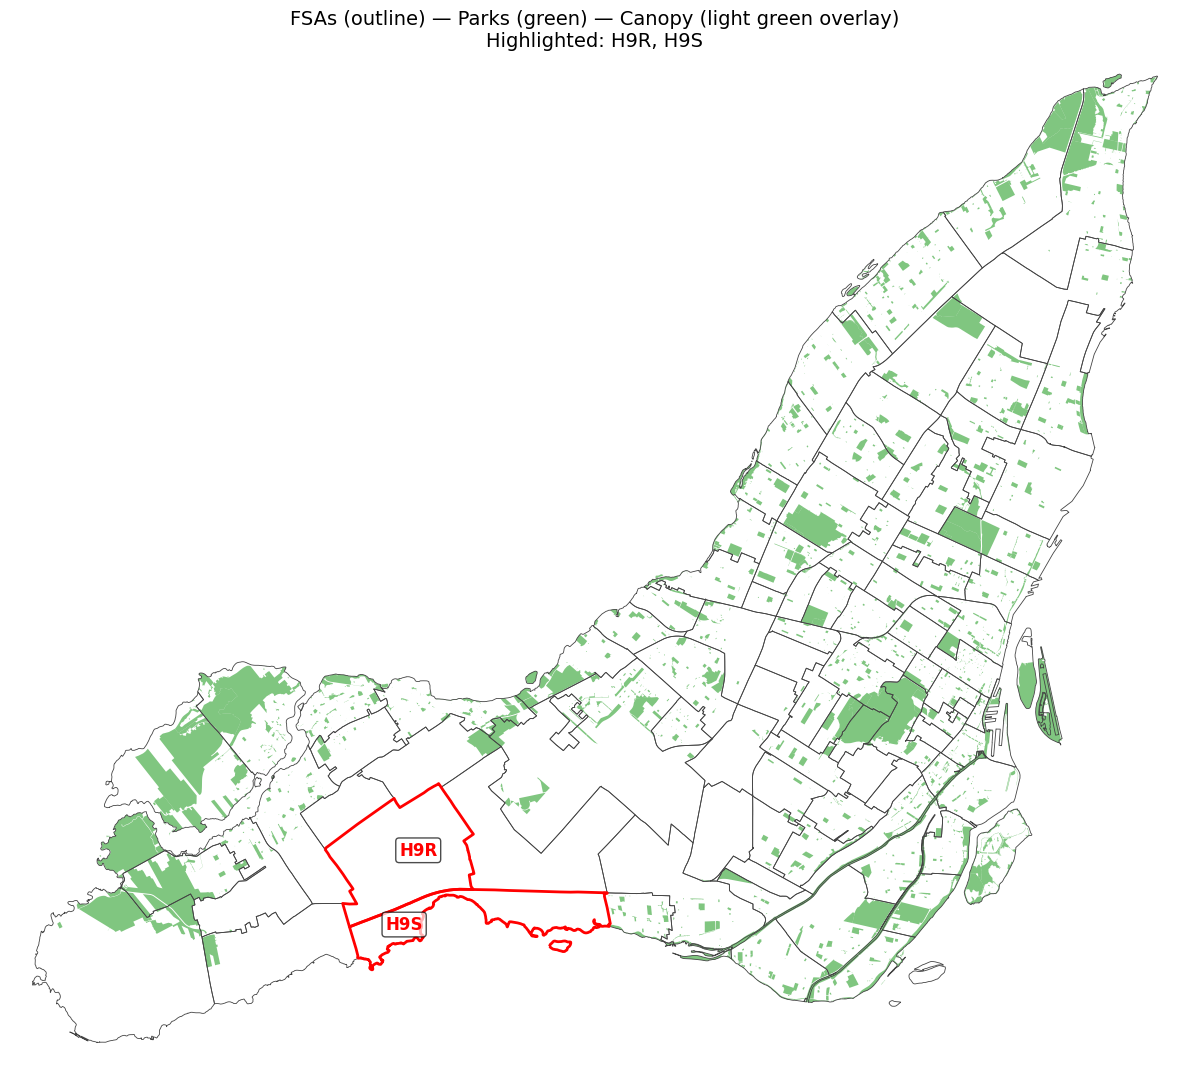

Saved PNG to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/debug_parks_canopy_map.png


In [32]:
# Simple matplotlib preview of FSAs, parks and canopy (static PNG)
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

proj_root = Path.cwd().parent
FSA_GEO = proj_root / "data" / "processed" / "fsa_master.geojson"
PARKS_GEO = proj_root / "data" / "raw" / "parks" / "espace_vert.geojson"
CANOPY_DIR = proj_root / "data" / "raw" / "canopy"
OUT_PNG = proj_root / "data" / "processed" / "debug_parks_canopy_map.png"

# load FSAs and parks
assert FSA_GEO.exists(), f"FSA file not found: {FSA_GEO}"
fsa = gpd.read_file(FSA_GEO).to_crs(epsg=3857)
print("Loaded FSAs:", len(fsa))
parks_exist = PARKS_GEO.exists()
if parks_exist:
    parks = gpd.read_file(PARKS_GEO).to_crs(epsg=3857)
    print("Loaded parks:", len(parks), "polygon types:", parks.geometry.type.value_counts().to_dict())
else:
    parks = None
    print("Parks file not found:", PARKS_GEO)

# check canopy (vector or raster)
canopy_found = None
canopy_path = None
if Path(CANOPY_DIR).exists():
    vecs = list(Path(CANOPY_DIR).glob("*.geojson")) + list(Path(CANOPY_DIR).glob("*.json")) + list(Path(CANOPY_DIR).glob("*.shp"))
    rasts = list(Path(CANOPY_DIR).glob("*.tif")) + list(Path(CANOPY_DIR).glob("*.tiff"))
    if vecs:
        canopy_found = "vector"
        canopy_path = vecs[0]
    elif rasts:
        canopy_found = "raster"
        canopy_path = rasts[0]
print("Canopy found:", canopy_found, canopy_path)

# start plotting
fig, ax = plt.subplots(1,1, figsize=(12,12))

# plot FSAs (light gray outline)
fsa.boundary.plot(ax=ax, linewidth=0.6, edgecolor="#444444")

# fill parks (if present)
if parks is not None and len(parks)>0:
    try:
        parks.plot(ax=ax, facecolor="#2ca02c", edgecolor=None, alpha=0.6, linewidth=0)
    except Exception:
        # fallback: only polygons
        parks[parks.geometry.type.isin(["Polygon","MultiPolygon"])].plot(ax=ax, facecolor="#2ca02c", edgecolor=None, alpha=0.6)

# overlay canopy
if canopy_found == "vector" and canopy_path is not None:
    try:
        canopy = gpd.read_file(canopy_path).to_crs(epsg=3857)
        canopy.plot(ax=ax, facecolor="#7fbf7f", edgecolor=None, alpha=0.35)
        print("Plotted canopy (vector) features:", len(canopy))
    except Exception as e:
        print("Could not plot canopy vector:", e)
elif canopy_found == "raster" and canopy_path is not None:
    try:
        import rasterio
        from rasterio.plot import show as rioshow
        src = rasterio.open(canopy_path)
        # read a single band and downsample for speed if large
        factor = max(1, int(max(src.width, src.height) / 1500))
        arr = src.read(1, out_shape=(int(src.height/factor), int(src.width/factor)))
        arr = np.nan_to_num(arr, nan=0)
        # extent in meters (EPSG:3857 assumption may be off — try to reproject extents)
        left, bottom, right, top = src.bounds
        # show raster with alpha
        ax.imshow(arr, origin='upper', extent=[left, right, bottom, top], cmap='Greens', alpha=0.35)
        print("Plotted canopy (raster) preview:", canopy_path.name)
    except Exception as e:
        print("Could not plot canopy raster (rasterio missing or error):", e)

# highlight H9R and H9S
for code, color in [("H9R","red"), ("H9S","red")]:
    sel = fsa[fsa.get("FSA_CODE", fsa.get("CFSAUID")).astype(str).str.upper() == code]
    if not sel.empty:
        sel.boundary.plot(ax=ax, edgecolor=color, linewidth=2)
        centroid = sel.to_crs(epsg=4326).geometry.representative_point().to_crs(epsg=3857).iloc[0]
        ax.text(centroid.x, centroid.y, code, fontsize=12, fontweight='bold', color=color,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

# zoom to the FSA extent (or full)
ax.set_axis_off()
# set extent to full FSAs
minx, miny, maxx, maxy = fsa.total_bounds
padx = (maxx - minx) * 0.02
pady = (maxy - miny) * 0.02
ax.set_xlim(minx - padx, maxx + padx)
ax.set_ylim(miny - pady, maxy + pady)

plt.title("FSAs (outline) — Parks (green) — Canopy (light green overlay)\nHighlighted: H9R, H9S", fontsize=14)
plt.tight_layout()
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_PNG, dpi=150)
plt.show()
print("Saved PNG to:", OUT_PNG)

This is a problem, clearly the dataset is missing some stuff. So I will try to work around it and add in the new canopy file in order to fill in these blanks with real greenspace data.

In [36]:
# Safe canopy (vector-first) integration into parks_score (no rasterio required)
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import math

proj_root = Path.cwd().parent
FSA_IN = proj_root / "data" / "processed" / "fsa_master.geojson"
CANOPY_DIR = proj_root / "data" / "raw" / "canopy"
OUT = FSA_IN

# weights (adjust w_canopy if you want)
w_canopy = 0.15
w_area = (1.0 - w_canopy) / 2.0
w_prox = (1.0 - w_canopy) / 2.0

print("Reading FSA:", FSA_IN)
g = gpd.read_file(FSA_IN)
if "FSA_CODE" not in g.columns:
    g["FSA_CODE"] = g.get("CFSAUID", g.index.astype(str)).astype(str)
g["FSA_CODE"] = g["FSA_CODE"].str.strip().str.upper()

g_m = g.to_crs(epsg=3857).copy()
g_m["fsa_area_km2"] = g_m.geometry.area / 1e6

# detect canopy files
canopy_path = None
canopy_type = None
cd = Path(CANOPY_DIR)
if cd.exists():
    vecs = list(cd.glob("*.geojson")) + list(cd.glob("*.json")) + list(cd.glob("*.shp"))
    rasts = list(cd.glob("*.tif")) + list(cd.glob("*.tiff"))
    if vecs:
        canopy_path = vecs[0]
        canopy_type = "vector"
    elif rasts:
        canopy_path = rasts[0]
        canopy_type = "raster"
else:
    canopy_type = None

print("Canopy detected:", canopy_type, canopy_path)

# initialize fields
g_m["canopy_area_km2"] = 0.0
g_m["canopy_fraction"] = 0.0
g_m["canopy_score"] = 0.0

if canopy_type == "vector":
    canopy = gpd.read_file(canopy_path).to_crs(epsg=3857)
    canopy_poly = canopy[canopy.geometry.type.isin(["Polygon","MultiPolygon"])].copy()
    print("Canopy polygons found:", len(canopy_poly))
    if not canopy_poly.empty:
        try:
            sj = gpd.sjoin(canopy_poly, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
        except Exception:
            sj = gpd.sjoin(canopy_poly, g_m[["FSA_CODE","geometry"]], how="inner", op='intersects')
        if not sj.empty:
            merged = sj.merge(g_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_can","_fsa"))
            areas = {}
            for idx, row in merged.iterrows():
                try:
                    inter = row.geometry_can.intersection(row.geometry_fsa)
                    if inter is not None and not inter.is_empty:
                        areas[row.FSA_CODE] = areas.get(row.FSA_CODE, 0.0) + inter.area
                except Exception:
                    pass
            g_m["canopy_area_km2"] = g_m["FSA_CODE"].map({k: v/1e6 for k,v in areas.items()}).fillna(0.0)
            g_m["canopy_fraction"] = g_m.apply(lambda r: (r["canopy_area_km2"]/r["fsa_area_km2"]) if r["fsa_area_km2"]>0 else 0.0, axis=1)
        else:
            print("No canopy polygon intersections found with FSAs.")
    else:
        print("Canopy vector file contains no polygons.")
elif canopy_type == "raster":
    print("Detected canopy raster but rasterio is not available in this environment.")
    print("If you want raster processing, install rasterio (recommended):")
    print("  pip install rasterio    OR    conda install -c conda-forge rasterio")
    print("Skipping raster canopy processing for now.")
else:
    print("No canopy dataset detected; canopy fields set to 0.")

# canopy_score normalization (min-max)
if g_m["canopy_fraction"].max() != g_m["canopy_fraction"].min():
    g_m["canopy_score"] = (g_m["canopy_fraction"] - g_m["canopy_fraction"].min()) / (g_m["canopy_fraction"].max() - g_m["canopy_fraction"].min())
else:
    g_m["canopy_score"] = 0.0

# ensure parks_area_score & parks_prox_score exist
if "parks_area_score" not in g_m.columns:
    if "parks_area_per_sqkm" in g_m.columns:
        s = g_m["parks_area_per_sqkm"].fillna(0).astype(float)
        g_m["parks_area_score"] = (s - s.min()) / (s.max() - s.min()) if s.max()!=s.min() else 0.0
    else:
        g_m["parks_area_score"] = 0.0

if "parks_prox_score" not in g_m.columns:
    if "parks_mean_distance_m" in g_m.columns:
        prox = g_m["parks_mean_distance_m"].fillna(g_m["parks_mean_distance_m"].max(skipna=True))
        g_m["parks_prox_score"] = 1.0 - ((prox - prox.min()) / (prox.max() - prox.min())) if prox.max()!=prox.min() else 0.0
    else:
        g_m["parks_prox_score"] = 0.0

# combine into parks_score with light canopy weight
g_m["parks_score_new"] = (w_area * g_m["parks_area_score"].fillna(0.0) +
                         w_prox * g_m["parks_prox_score"].fillna(0.0) +
                         w_canopy * g_m["canopy_score"].fillna(0.0))
g_m["parks_score"] = g_m["parks_score_new"]

# recompute final_score as mean of available components
components = [c for c in ["crime_score","parks_score","transit_score"] if c in g_m.columns]
if components:
    g_m["final_score"] = g_m[components].fillna(0.0).mean(axis=1)

# write back to GeoJSON
g_out = g_m.to_crs(epsg=4326)
g_out.to_file(OUT, driver="GeoJSON")
print("Wrote updated GeoJSON to:", OUT)
print("Canopy type used:", canopy_type)
print("FSAs with canopy_fraction > 0:", (g_out["canopy_fraction"]>0).sum(), "/", len(g_out))
print("Canopy fraction range:", float(g_out["canopy_fraction"].min()), "->", float(g_out["canopy_fraction"].max()))
display(g_out[g_out["FSA_CODE"].isin(["H9R","H9S"])][["FSA_CODE","parks_count","parks_area_per_sqkm","parks_mean_distance_m","canopy_fraction","canopy_area_km2","parks_score","final_score"]])

Reading FSA: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Canopy detected: vector /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/canopy/canopee-2019.geojson


INFO:pyogrio._io:Created 97 records


Canopy polygons found: 514124
No canopy polygon intersections found with FSAs.
Wrote updated GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Canopy type used: vector
FSAs with canopy_fraction > 0: 0 / 97
Canopy fraction range: 0.0 -> 0.0


,FSA_CODE,parks_count,parks_area_per_sqkm,parks_mean_distance_m,canopy_fraction,canopy_area_km2,parks_score,final_score
79,H9R,0,0.000000,4041.265190,0.0,0.0,0.109583,0.377903
80,H9S,0,0.000029,4018.725681,0.0,0.0,0.000017,0.407081


Weird, this does not seem good, let's visualize it to confirm this result, since I already know this area is quite vegetated.

FSA bounds (lat/lon): [-73.9763996   45.40212923 -73.47606598  45.70374748]
FSA bounds (meters EPSG:3857): [-8235015.13459948  5685052.2320863  -8179318.25011885  5733000.98034847]
Canopy path: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/canopy/canopee-2019.geojson
Declared canopy CRS: EPSG:4326
Canopy raw bounds: [ 267515.375      5029228.62499946  306658.125      5062653.87499946]
Sample geom coord example (first polygon exterior 6 pts if polygon):
[(299710.62499999884, 5039334.874999461), (299711.37500000023, 5039336.37499946), (299709.87499999924, 5039339.37499946), (299711.37499999965, 5039340.12499946), (299710.6249999996, 5039342.374999461), (299713.6249999987, 5039343.12499946)]
Canopy coords appear lon/lat-like?: False
Attempting candidate CRSes: [32618, 26918, 3857, 3347, 32198]
 EPSG:32618 -> intersection rows (sampled): 0
 EPSG:26918 -> intersection rows (sampled): 0
 EPSG:3857 -> intersection rows (sampled): 0
 EPSG:3347 -> intersection r

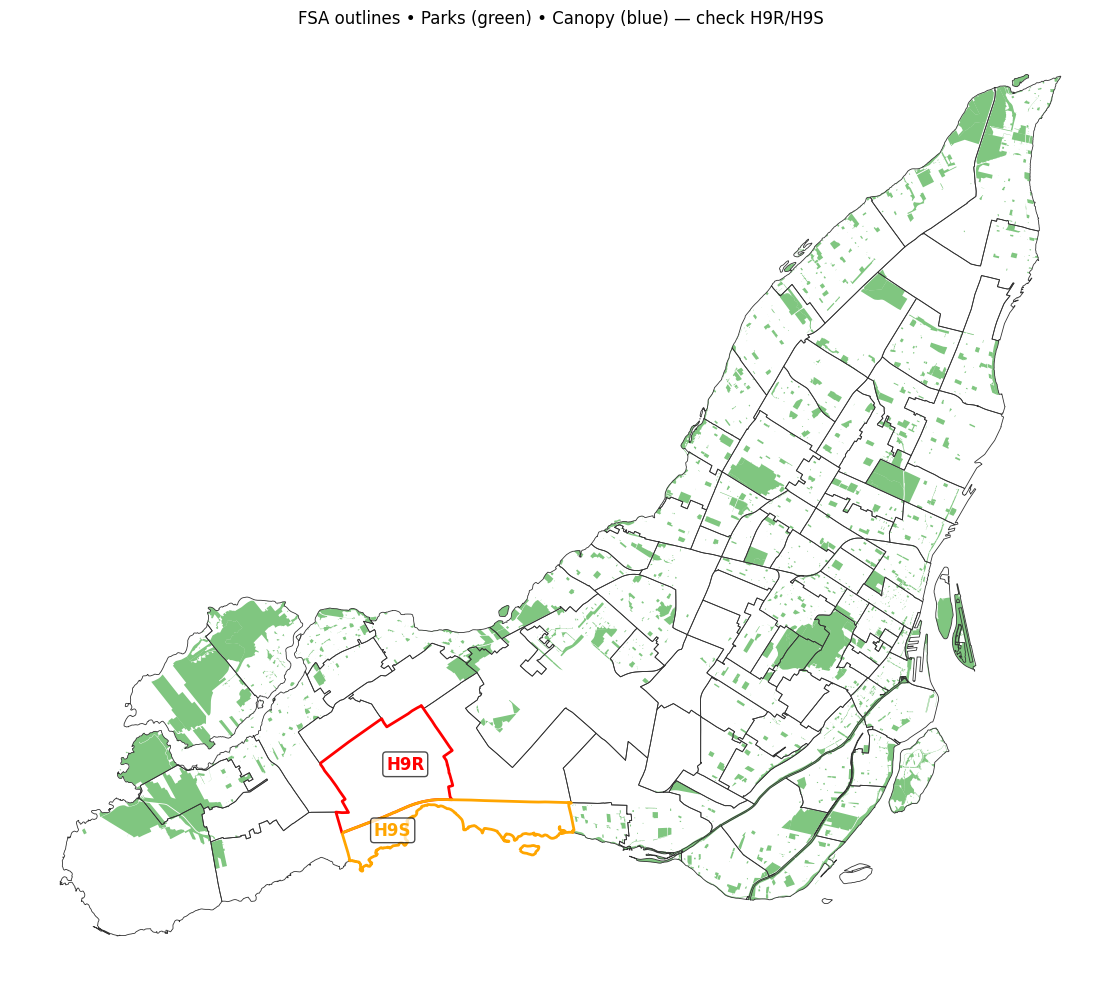

Saved visualization to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/debug_canopy_fixed_vs_fsa.png

Done. If a CRS was chosen above, canopy intersections were written to the GeoJSON. If not, tell me and I will try additional CRSes or a manual reprojection.


In [39]:
# Try likely CRSes for canopy (when declared CRS is wrong), test intersections, pick working CRS and compute canopy per-FSA
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.ops import unary_union
from shapely.geometry import mapping

proj_root = Path.cwd().parent
FSA = proj_root / "data" / "processed" / "fsa_master.geojson"
CANOPY_DIR = proj_root / "data" / "raw" / "canopy"
OUT_GEO = FSA
OUT_PNG = proj_root / "data" / "processed" / "debug_canopy_fixed_vs_fsa.png"

# load FSAs
fsa = gpd.read_file(FSA)
fsa = fsa.to_crs(epsg=4326)
fsa_m = fsa.to_crs(epsg=3857)  # metric for area tests
bbox = fsa_m.total_bounds
print("FSA bounds (lat/lon):", fsa.total_bounds)
print("FSA bounds (meters EPSG:3857):", bbox)

# find canopy file
cd = Path(CANOPY_DIR)
vecs = []
if cd.exists():
    vecs = list(cd.glob("*.geojson")) + list(cd.glob("*.json")) + list(cd.glob("*.shp"))
if not vecs:
    raise RuntimeError("No canopy vector file found in data/raw/canopy")
canopy_path = vecs[0]
print("Canopy path:", canopy_path)

# load canopy (do NOT trust its declared CRS)
canopy = gpd.read_file(canopy_path)
print("Declared canopy CRS:", canopy.crs)
print("Canopy raw bounds:", canopy.total_bounds[:4])
print("Sample geom coord example (first polygon exterior 6 pts if polygon):")
g0 = canopy.geometry.iloc[0]
if g0.geom_type in ("Polygon","MultiPolygon"):
    poly = list(g0.geoms)[0] if g0.geom_type=="MultiPolygon" else g0
    print(list(poly.exterior.coords)[:6])
else:
    print("geom type:", g0.geom_type, "wkt sample:", g0.wkt[:200])

# quick helper: test intersection count with FSAs for a canopy GDF (works on sampled subset)
def test_intersections(can_gdf, fsa_gdf, reproject_to=3857, sample_limit=20000):
    try:
        cg = can_gdf.to_crs(epsg=reproject_to)
        fg = fsa_gdf.to_crs(epsg=reproject_to)
    except Exception as e:
        print("Reprojection error:", e)
        return 0
    minx, miny, maxx, maxy = fg.total_bounds
    pad = max(maxx-minx, maxy-miny) * 0.02
    try:
        cx = cg.cx[minx-pad:maxx+pad, miny-pad:maxy+pad]
    except Exception:
        cx = cg
    if len(cx) == 0:
        return 0
    if len(cx) > sample_limit:
        cx = cx.sample(sample_limit, random_state=1)
    try:
        sj = gpd.sjoin(cx, fg[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
    except Exception:
        sj = gpd.sjoin(cx, fg[["FSA_CODE","geometry"]], how="inner", op='intersects')
    return len(sj)

# If canopy coords are outside lon/lat, try candidate CRSes
xs, ys, x_max, y_max = canopy.total_bounds
lonlat_ok = (-180 <= xs <= 180) and (-90 <= ys <= 90) and (-180 <= x_max <= 180) and (-90 <= y_max <= 90)
print("Canopy coords appear lon/lat-like?:", lonlat_ok)

chosen_crs = None
if lonlat_ok:
    # declared coords look like lon/lat; test direct intersection
    cnt = test_intersections(canopy, fsa)
    print("Intersections with declared CRS:", cnt)
    if cnt > 0:
        chosen_crs = canopy.crs
else:
    # try plausible candidate CRSes (UTM zone 18N / NAD83 / WGS84, plus WebMercator and some Canadian LCC)
    candidates = [32618, 26918, 3857, 3347, 32198]  # EPSG codes
    print("Attempting candidate CRSes:", candidates)
    for epsg in candidates:
        try:
            # assign this CRS (without transforming) and test intersects
            temp = canopy.copy()
            temp = temp.set_crs(epsg=epsg, allow_override=True)
            cnt = test_intersections(temp, fsa)
            print(f" EPSG:{epsg} -> intersection rows (sampled): {cnt}")
            if cnt > 0:
                chosen_crs = f"EPSG:{epsg}"
                print("Selected CRS:", chosen_crs)
                break
        except Exception as e:
            print("Failed EPSG:", epsg, "error:", e)
            continue

if chosen_crs is None:
    print("No candidate CRS produced intersections. Canopy may be in a different CRS or coordinates are offset. We will still produce a visualization of the raw canopy (blue) vs FSAs (gray).")
else:
    # assign chosen_crs to canopy and reproject properly
    epsg_num = int(str(chosen_crs).split(":")[-1]) if isinstance(chosen_crs, str) and ":" in str(chosen_crs) else int(chosen_crs) if isinstance(chosen_crs, int) else None
    if epsg_num:
        canopy = canopy.set_crs(epsg=epsg_num, allow_override=True)
    print("Using canopy CRS:", canopy.crs)
    # compute exact intersection areas to update FSA canopy fields (metric)
    canopy_m = canopy.to_crs(epsg=3857)
    fsa_m = fsa.to_crs(epsg=3857)
    # limit canopy to bbox for speed
    minx, miny, maxx, maxy = fsa_m.total_bounds
    pad = max(maxx-minx, maxy-miny) * 0.02
    canopy_clip = canopy_m.cx[minx-pad:maxx+pad, miny-pad:maxy+pad]
    print("Canopy features within FSA bbox (for exact intersection):", len(canopy_clip))
    if len(canopy_clip) == 0:
        print("No canopy features within the FSA bbox even after assigning CRS:", canopy.crs)
    else:
        # spatial join then intersection-by-FSA
        try:
            sj = gpd.sjoin(canopy_clip, fsa_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
        except Exception:
            sj = gpd.sjoin(canopy_clip, fsa_m[["FSA_CODE","geometry"]], how="inner", op='intersects')
        if sj.empty:
            print("Spatial join returned zero rows after clipping (unexpected).")
        else:
            merged = sj.merge(fsa_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_can","_fsa"))
            areas = {}
            for idx, row in merged.iterrows():
                try:
                    inter = row.geometry_can.intersection(row.geometry_fsa)
                    if inter is not None and not inter.is_empty:
                        areas[row.FSA_CODE] = areas.get(row.FSA_CODE, 0.0) + inter.area
                except Exception:
                    pass
            # assign canopy area (km2) and fraction
            fsa_m["canopy_area_km2"] = fsa_m["FSA_CODE"].map({k:v/1e6 for k,v in areas.items()}).fillna(0.0)
            fsa_m["canopy_fraction"] = fsa_m.apply(lambda r: (r["canopy_area_km2"]/ (r.geometry.area/1e6)) if r.geometry and r.geometry.area>0 else 0.0, axis=1)

            # merge these back into the WGS84 GeoJSON and save
            fsa_updated = fsa_m.to_crs(epsg=4326)
            # ensure columns exist
            if "canopy_area_km2" not in fsa_updated.columns:
                fsa_updated["canopy_area_km2"] = 0.0
            if "canopy_fraction" not in fsa_updated.columns:
                fsa_updated["canopy_fraction"] = 0.0
            fsa_updated.to_file(OUT_GEO, driver="GeoJSON")
            print("Wrote updated GeoJSON with canopy intersections to:", OUT_GEO)

# Create visualization (raw canopy and, if chosen, correctly reprojected canopy)
print("Creating visualization PNG...")
fsa_plot = fsa.to_crs(epsg=3857)
parks = None
parks_path = proj_root / "data" / "raw" / "parks" / "espace_vert.geojson"
if parks_path.exists():
    parks = gpd.read_file(parks_path).to_crs(epsg=3857)
# raw canopy as read (no spatial transform)
canopy_raw = canopy.copy()
# if chosen_crs was found, canopy was assigned above; ensure we have a canopy_m for plotting
canopy_m_plot = None
if chosen_crs is not None:
    canopy_m_plot = canopy.to_crs(epsg=3857)
else:
    # attempt to plot raw coords (they may be in projected units already)
    try:
        canopy_m_plot = canopy.to_crs(epsg=3857)
    except Exception:
        canopy_m_plot = None

fig, ax = plt.subplots(1,1, figsize=(12,10))
fsa_plot.boundary.plot(ax=ax, linewidth=0.6, edgecolor="#333333")
if parks is not None and len(parks)>0:
    parks.plot(ax=ax, facecolor="#2ca02c", edgecolor=None, alpha=0.6)
# canopy raw/converted
if canopy_m_plot is not None and len(canopy_m_plot)>0:
    try:
        canopy_m_plot.plot(ax=ax, facecolor="#2b6fb3", edgecolor=None, alpha=0.35)
        print("Plotted canopy (projected) features for visual check:", len(canopy_m_plot))
    except Exception:
        print("Could not plot canopy_m_plot")
else:
    print("No canopy_m_plot available for plotting.")

# highlight H9R/H9S
for code, color in [("H9R","red"), ("H9S","orange")]:
    sel = fsa_plot[fsa_plot.get("FSA_CODE", fsa_plot.get("CFSAUID")).astype(str).str.upper()==code]
    if not sel.empty:
        sel.boundary.plot(ax=ax, edgecolor=color, linewidth=2)
        pt = sel.geometry.representative_point().iloc[0]
        ax.text(pt.x, pt.y, code, fontsize=12, fontweight='bold', color=color,
                bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))

ax.set_axis_off()
plt.title("FSA outlines • Parks (green) • Canopy (blue) — check H9R/H9S")
plt.tight_layout()
OUT_PNG.parent.mkdir(parents=True, exist_ok=True)
plt.savefig(OUT_PNG, dpi=150)
plt.show()
print("Saved visualization to:", OUT_PNG)

print("\nDone. If a CRS was chosen above, canopy intersections were written to the GeoJSON. If not, tell me and I will try additional CRSes or a manual reprojection.")

Not looking good, same crap. So let's trim the canopy file down in order to take a look at what we have. 

Canopy file: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/raw/canopy/canopee-2019.geojson
Total canopy features: 514124


/var/folders/sp/ncf_7dk94k1gshvvrt4r_hth0000gn/T/ipykernel_13073/4180940122.py:36: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  centroids = canopy.geometry.centroid


Candidate counts (EPSG -> matched centroids in Montreal bbox):
 EPSG:2950 -> 514124
 EPSG:32188 -> 514124
 EPSG:3347 -> 0
 EPSG:32198 -> 0
 EPSG:26918 -> 0
 EPSG:32618 -> 0
 EPSG:3857 -> 0
 EPSG:4326 -> 0
Selected EPSG:2950 (matched 514124 centroid(s))
Assigning canopy CRS to EPSG: 2950 and transforming to EPSG:4326 (this may take a bit)...


/var/folders/sp/ncf_7dk94k1gshvvrt4r_hth0000gn/T/ipykernel_13073/4180940122.py:79: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  mask = (canopy_wgs.geometry.centroid.x >= mont_lon_min) & (canopy_wgs.geometry.centroid.x <= mont_lon_max) & \
/var/folders/sp/ncf_7dk94k1gshvvrt4r_hth0000gn/T/ipykernel_13073/4180940122.py:80: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  (canopy_wgs.geometry.centroid.y >= mont_lat_min) & (canopy_wgs.geometry.centroid.y <= mont_lat_max)


Canopy features after clipping (WGS84 centroid test): 514124


INFO:pyogrio._io:Created 514,124 records


Saved clipped canopy to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/canopy_montreal.geojson
Producing preview PNG...


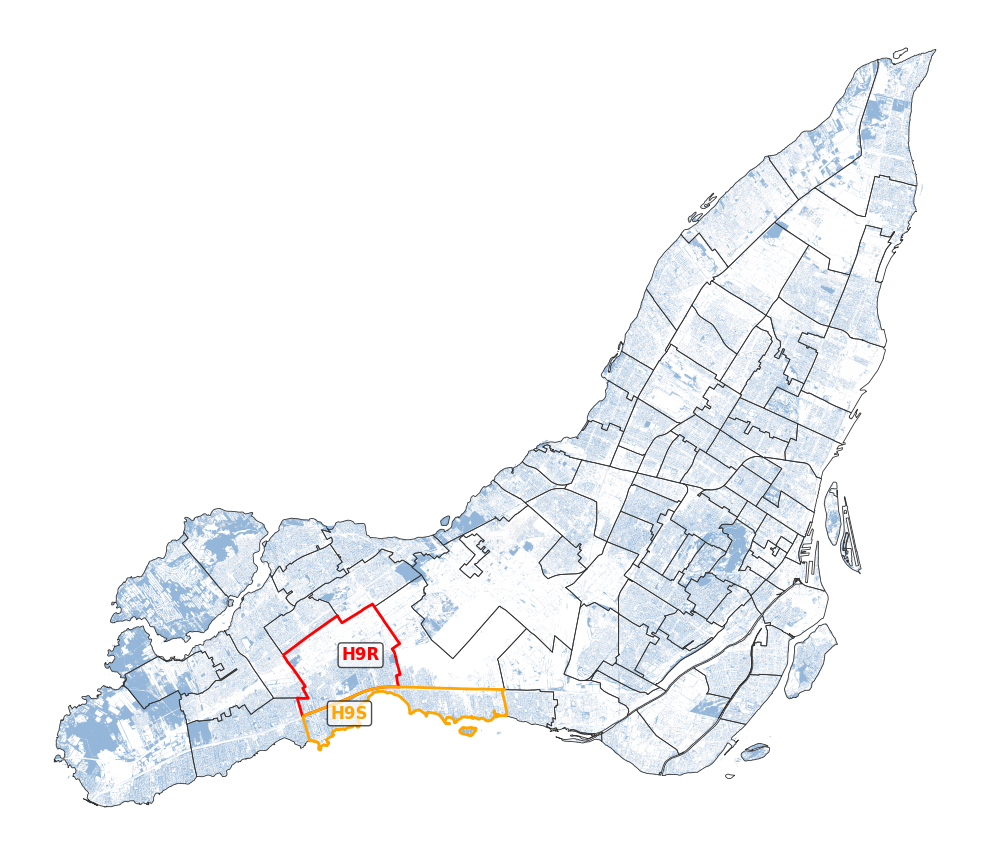

Saved preview PNG to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/canopy_montreal_preview.png


In [40]:
# Clip canopy to Montreal by testing likely projected CRSes, then save clip + preview PNG
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Point

proj_root = Path.cwd().parent
CANOPY_DIR = proj_root / "data" / "raw" / "canopy"
CANOPY_OUT = proj_root / "data" / "processed" / "canopy_montreal.geojson"
PREVIEW_PNG = proj_root / "data" / "processed" / "canopy_montreal_preview.png"
FSA_GEO = proj_root / "data" / "processed" / "fsa_master.geojson"

# Montreal bbox in lon/lat (a bit padded)
mont_lon_min, mont_lon_max = -74.3, -73.2
mont_lat_min, mont_lat_max = 45.2, 45.8

# candidates for canopy CRS (common Canadian/projected CRSes to try)
candidates = [3347, 32198, 2950, 32188, 26918, 32618, 3857, 4326]

# find canopy file
cd = Path(CANOPY_DIR)
vecs = []
if cd.exists():
    vecs = list(cd.glob("*.geojson")) + list(cd.glob("*.json")) + list(cd.glob("*.shp"))
if not vecs:
    raise RuntimeError("No canopy vector found in data/raw/canopy")
canopy_path = vecs[0]
print("Canopy file:", canopy_path)

# load canopy but only read geometry + a small number of properties to save memory
canopy = gpd.read_file(canopy_path)
print("Total canopy features:", len(canopy))
# compute centroids (in the file's declared CRS) for candidate testing
centroids = canopy.geometry.centroid
centroids_gdf = gpd.GeoDataFrame(geometry=centroids, crs=canopy.crs)

# function to test a candidate CRS by assigning it and transforming centroids to 4326
def count_in_montreal_if_assigned(crs_epsg):
    try:
        temp = centroids_gdf.copy()
        # assign candidate CRS without changing coordinates
        temp = temp.set_crs(epsg=crs_epsg, allow_override=True)
        wgs = temp.to_crs(epsg=4326)
        xs = wgs.geometry.x.values
        ys = wgs.geometry.y.values
        mask = (xs >= mont_lon_min) & (xs <= mont_lon_max) & (ys >= mont_lat_min) & (ys <= mont_lat_max)
        return int(mask.sum())
    except Exception as e:
        # assignment / transform failed for this candidate
        return 0

# test candidates (report top matches)
results = []
for epsg in candidates:
    cnt = count_in_montreal_if_assigned(epsg)
    results.append((epsg, cnt))
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)
print("Candidate counts (EPSG -> matched centroids in Montreal bbox):")
for epsg, cnt in results_sorted:
    print(f" EPSG:{epsg} -> {cnt}")

# pick best candidate if it has some matches
best_epsg, best_cnt = results_sorted[0]
chosen_epsg = None
if best_cnt > 50:  # threshold for "likely correct" (adjust if needed)
    chosen_epsg = int(best_epsg)
    print(f"Selected EPSG:{chosen_epsg} (matched {best_cnt} centroid(s))")
else:
    print("No single candidate produced many centroid matches; will attempt a heuristic bbox in canopy native coords as fallback.")

# If chosen, transform full canopy to 4326 and clip to Montreal bbox
if chosen_epsg is not None:
    print("Assigning canopy CRS to EPSG:", chosen_epsg, "and transforming to EPSG:4326 (this may take a bit)...")
    canopy_assigned = canopy.set_crs(epsg=chosen_epsg, allow_override=True)
    canopy_wgs = canopy_assigned.to_crs(epsg=4326)
    # filter by Montreal bbox
    mask = (canopy_wgs.geometry.centroid.x >= mont_lon_min) & (canopy_wgs.geometry.centroid.x <= mont_lon_max) & \
           (canopy_wgs.geometry.centroid.y >= mont_lat_min) & (canopy_wgs.geometry.centroid.y <= mont_lat_max)
    canopy_clip = canopy_wgs[mask].copy()
    print("Canopy features after clipping (WGS84 centroid test):", len(canopy_clip))
    if len(canopy_clip) == 0:
        # fallback: use any geometry that intersects the bbox polygon
        from shapely.geometry import box
        bb = box(mont_lon_min, mont_lat_min, mont_lon_max, mont_lat_max)
        canopy_clip = canopy_wgs[canopy_wgs.intersects(bb)].copy()
        print("Fallback: features intersecting Montreal bbox:", len(canopy_clip))
    if len(canopy_clip) > 0:
        canopy_clip.to_file(CANOPY_OUT, driver="GeoJSON")
        print("Saved clipped canopy to:", CANOPY_OUT)
else:
    # fallback: use numeric bbox in canopy's native coordinates to select features (fast heuristic)
    # compute canopy total bounds
    minx, miny, maxx, maxy = canopy.total_bounds
    print("Canopy native bounds:", (minx, miny, maxx, maxy))
    # Heuristic: take a small central window around canopy's densest centroids by taking centroids and clustering by proximity to median
    cent = np.vstack([centroids_gdf.geometry.x.values, centroids_gdf.geometry.y.values]).T
    medx, medy = np.median(cent[:,0]), np.median(cent[:,1])
    # Define a window of +/- 30 km in native units (approx) around median
    window = 30000
    win_minx, win_maxx = medx-window, medx+window
    win_miny, win_maxy = medy-window, medy+window
    print("Heuristic numeric window in canopy native coords:", (win_minx, win_miny, win_maxx, win_maxy))
    # select canopy centroids inside this numeric window
    mask_native = (centroids_gdf.geometry.x >= win_minx) & (centroids_gdf.geometry.x <= win_maxx) & \
                  (centroids_gdf.geometry.y >= win_miny) & (centroids_gdf.geometry.y <= win_maxy)
    ids = np.nonzero(mask_native)[0]
    print("Centroids inside heuristic window:", len(ids))
    if len(ids) == 0:
        # widen window
        window2 = 100000
        win_minx, win_maxx = medx-window2, medx+window2
        win_miny, win_maxy = medy-window2, medy+window2
        mask_native = (centroids_gdf.geometry.x >= win_minx) & (centroids_gdf.geometry.x <= win_maxx) & \
                      (centroids_gdf.geometry.y >= win_miny) & (centroids_gdf.geometry.y <= win_maxy)
        ids = np.nonzero(mask_native)[0]
        print("After widening, centroids inside window:", len(ids))
    if len(ids) > 0:
        # select those canopy features
        canopy_clip = canopy.iloc[ids].copy()
        canopy_clip.to_file(CANOPY_OUT, driver="GeoJSON")
        print("Saved heuristic-clipped canopy to:", CANOPY_OUT)
    else:
        print("Heuristic clipping found nothing. No canopy clip was produced.")
        canopy_clip = None

# produce a quick preview PNG plotting FSAs + clipped canopy if any
print("Producing preview PNG...")
fsa = gpd.read_file(FSA_GEO).to_crs(epsg=3857)
if 'canopy_clip' in locals() and canopy_clip is not None and len(canopy_clip) > 0:
    try:
        canopy_plot = canopy_clip.to_crs(epsg=3857)
    except Exception:
        canopy_plot = canopy_clip
    fig, ax = plt.subplots(1,1, figsize=(10,10))
    fsa.boundary.plot(ax=ax, linewidth=0.6, edgecolor="#333333")
    try:
        canopy_plot.plot(ax=ax, facecolor="#2b6fb3", edgecolor=None, alpha=0.5)
    except Exception:
        # maybe mixed geometries
        try:
            canopy_plot[canopy_plot.geometry.type.isin(["Polygon","MultiPolygon"])].plot(ax=ax, facecolor="#2b6fb3", alpha=0.5)
        except Exception:
            pass
    # highlight H9R / H9S
    for code,color in [("H9R","red"),("H9S","orange")]:
        sel = fsa[fsa.get("FSA_CODE", fsa.get("CFSAUID")).astype(str).str.upper()==code]
        if not sel.empty:
            sel.boundary.plot(ax=ax, edgecolor=color, linewidth=2)
            pt = sel.geometry.representative_point().iloc[0]
            ax.text(pt.x, pt.y, code, fontsize=12, fontweight='bold', color=color,
                    bbox=dict(facecolor='white', alpha=0.7, boxstyle='round,pad=0.2'))
    ax.set_axis_off()
    plt.tight_layout()
    PREVIEW_PNG.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(PREVIEW_PNG, dpi=150)
    plt.show()
    print("Saved preview PNG to:", PREVIEW_PNG)
else:
    print("No clipped canopy available to preview. Nothing plotted.")

This makes a lot more sense. Let's do a reweight of the parks index.

In [41]:
# Recompute parks_score with heavy canopy weight and update final_score, save fsa_master.geojson
from pathlib import Path
import geopandas as gpd
import pandas as pd
import numpy as np

proj_root = Path.cwd().parent
FSA_IN = proj_root / "data" / "processed" / "fsa_master.geojson"
CANOPY_CLIP = proj_root / "data" / "processed" / "canopy_montreal.geojson"  # clipped canopy
OUT = FSA_IN

# weights (heavy canopy) can change this later as desired
w_canopy = 0.50
w_area = 0.30
w_prox = 0.20

print("Loading FSA:", FSA_IN)
g = gpd.read_file(FSA_IN)
g["FSA_CODE"] = g.get("FSA_CODE", g.get("CFSAUID")).astype(str).str.strip().str.upper()

# metric copy for intersections
g_m = g.to_crs(epsg=3857).copy()
g_m["fsa_area_km2"] = g_m.geometry.area / 1e6

# load canopy clip if present
canopy_area_km2 = {}
if CANOPY_CLIP.exists():
    print("Loading clipped canopy:", CANOPY_CLIP)
    canopy = gpd.read_file(CANOPY_CLIP).to_crs(epsg=3857)
    canopy_poly = canopy[canopy.geometry.type.isin(["Polygon","MultiPolygon"])].copy()
    print("Canopy features (polygons):", len(canopy_poly))
    if not canopy_poly.empty:
        # spatial join canopy -> FSA and compute intersection area per FSA
        sj = gpd.sjoin(canopy_poly, g_m[["FSA_CODE","geometry"]], how="inner", predicate="intersects")
        if not sj.empty:
            merged = sj.merge(g_m[["FSA_CODE","geometry"]], on="FSA_CODE", suffixes=("_can","_fsa"))
            pa = {}
            for idx, row in merged.iterrows():
                try:
                    inter = row.geometry_can.intersection(row.geometry_fsa)
                    if inter is not None and not inter.is_empty:
                        pa[row.FSA_CODE] = pa.get(row.FSA_CODE, 0.0) + inter.area
                except Exception:
                    pass
            canopy_area_km2 = {k: v/1e6 for k,v in pa.items()}
else:
    print("No canopy clip found at", CANOPY_CLIP, "- canopy_fraction will be zero.")

# assign canopy fields to g_m
g_m["canopy_area_km2"] = g_m["FSA_CODE"].map(canopy_area_km2).fillna(0.0)
g_m["canopy_fraction"] = g_m.apply(lambda r: (r["canopy_area_km2"] / r["fsa_area_km2"]) if r["fsa_area_km2"]>0 else 0.0, axis=1)

# normalize canopy_score (min-max)
if g_m["canopy_fraction"].max() != g_m["canopy_fraction"].min():
    g_m["canopy_score"] = (g_m["canopy_fraction"] - g_m["canopy_fraction"].min()) / (g_m["canopy_fraction"].max() - g_m["canopy_fraction"].min())
else:
    g_m["canopy_score"] = 0.0

# ensure parks area & proximity scores exist (fallback to earlier fields)
if "parks_area_score" not in g_m.columns:
    if "parks_area_per_sqkm" in g_m.columns:
        s = g_m["parks_area_per_sqkm"].fillna(0.0).astype(float)
        g_m["parks_area_score"] = (s - s.min()) / (s.max() - s.min()) if s.max()!=s.min() else 0.0
    else:
        g_m["parks_area_score"] = 0.0

if "parks_prox_score" not in g_m.columns:
    if "parks_mean_distance_m" in g_m.columns:
        prox = g_m["parks_mean_distance_m"].fillna(g_m["parks_mean_distance_m"].max(skipna=True))
        g_m["parks_prox_score"] = 1.0 - ((prox - prox.min()) / (prox.max() - prox.min())) if prox.max()!=prox.min() else 0.0
    else:
        g_m["parks_prox_score"] = 0.0

# new parks_score blending canopy heavily
g_m["parks_score"] = (w_canopy * g_m["canopy_score"].fillna(0.0) +
                      w_area * g_m["parks_area_score"].fillna(0.0) +
                      w_prox * g_m["parks_prox_score"].fillna(0.0))

# recompute final_score as mean of available components
components = [c for c in ["crime_score","parks_score","transit_score"] if c in g_m.columns]
if components:
    g_m["final_score"] = g_m[components].fillna(0.0).mean(axis=1)
else:
    g_m["final_score"] = g_m.get("final_score", 0.0)

# write back to GeoJSON (WGS84)
g_out = g_m.to_crs(epsg=4326)
g_out.to_file(OUT, driver="GeoJSON")
print("Wrote updated master GeoJSON to:", OUT)
print("FSAs with canopy_fraction > 0:", int((g_out['canopy_fraction']>0).sum()), "/", len(g_out))
print("Canopy fraction range:", float(g_out['canopy_fraction'].min()), "->", float(g_out['canopy_fraction'].max()))
# sample H9R/H9S
display(g_out[g_out["FSA_CODE"].isin(["H9R","H9S"])][["FSA_CODE","parks_area_per_sqkm","parks_mean_distance_m","canopy_fraction","canopy_area_km2","parks_score","final_score"]])

Loading FSA: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
Loading clipped canopy: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/canopy_montreal.geojson
Canopy features (polygons): 514124


INFO:pyogrio._io:Created 97 records


Wrote updated master GeoJSON to: /Users/tylercoull/Desktop/(ConU)/ConU F25/GEOG 464/NewFinal/RentAtlas/data/processed/fsa_master.geojson
FSAs with canopy_fraction > 0: 97 / 97
Canopy fraction range: 0.06824648616845395 -> 0.5620946926593017


,FSA_CODE,parks_area_per_sqkm,parks_mean_distance_m,canopy_fraction,canopy_area_km2,parks_score,final_score
79,H9R,0.000000,4041.265190,0.240337,7.400029,0.225803,0.416643
80,H9S,0.000029,4018.725681,0.336321,6.437993,0.271426,0.497551
